In [27]:
%config IPCompleter.use_jedi = False
%pdb off
%load_ext autoreload
%autoreload 3

# required to enable non-blocking interaction:
%gui qt5

import sys
from copy import deepcopy
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from neuropy.utils.result_context import IdentifyingContext
from nptyping import NDArray
import neuropy.utils.type_aliases as types
from collections import defaultdict
from functools import partial

import numpy as np
import pandas as pd
import re
from pathlib import Path
from datetime import datetime

from neuropy.utils.indexing_helpers import PandasHelpers
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphocorehelpers.indexing_helpers import partition_df
# Set the maximum number of columns to display
pd.set_option('display.max_columns', 100)

import IPython
from pyphocorehelpers.programming_helpers import IPythonHelpers
from pyphocorehelpers.notebook_helpers import NotebookCellExecutionLogger
from pyphocorehelpers.assertion_helpers import Assert

# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

_notebook_path:Path = Path(IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())).resolve() # Finds the path of THIS notebook

# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')

# Switch to the desired interactivity mode
plt.interactive(True)

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
template: str = 'plotly_dark' # set plotl template
pio.templates.default = template
from pyphocorehelpers.plotting.media_output_helpers import fig_to_clipboard
from pyphocorehelpers.Filesystem.path_helpers import file_uri_from_path, sanitize_filename_for_Windows
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, simple_path_display_widget
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results
from pyphocorehelpers.assertion_helpers import Assert

# from ..PendingNotebookCode import plot_across_sessions_scatter_results, plot_histograms, plot_stacked_histograms
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import find_csv_files, find_HDF5_files, find_most_recent_files
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_histograms, plot_stacked_histograms

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_files, _process_and_load_exported_file, _common_cleanup_operations

from pyphocorehelpers.programming_helpers import metadata_attributes
from pyphocorehelpers.function_helpers import function_attributes

from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import build_session_t_delta, _new_process_csv_files
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import DataFrameFilter
from pyphocorehelpers.plotting.media_output_helpers import figure_to_pil_image, vertical_image_stack, horizontal_image_stack, image_grid

debug_print: bool = False
enable_neptune: bool = False

_TODAY_DAY_ONLY_DATE: str = "2024-11-05"
TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_Apogee"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_GL"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_Lab"
# TODAY_DAY_DATE: str = f"{_TODAY_DAY_ONLY_DATE}_rMBP"

print(f'TODAY_DAY_DATE: {TODAY_DAY_DATE}')

types.session_str: TypeAlias = str # a unique session identifier

if enable_neptune:
	import neptune # for logging progress and results
	from neptune.types import File
	from pyphoplacecellanalysis.General.Batch.NeptuneAiHelpers import Neptuner, AutoValueConvertingNeptuneRun, set_environment_variables 

	## Gets the notebook filepath for Neptune:
	import IPython
	from pyphocorehelpers.programming_helpers import IPythonHelpers
	notebook_filepath: str = IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())
	assert Path(notebook_filepath).resolve().exists(), f"found notebook filepath: '{notebook_filepath}' does not exist"
	# notebook_filepath

	neptune_kwargs = {'project':"commander.pho/PhoDibaLongShortAcrossSessions",
	'api_token':"eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGIxODU2My1lZTNhLTQ2ZWMtOTkzNS02ZTRmNzM5YmNjNjIifQ=="}
			
	neptuner = Neptuner(project_name=neptune_kwargs['project'], api_token=neptune_kwargs['api_token'])


	if neptuner.run is None:
		neptuner.run = AutoValueConvertingNeptuneRun(project=neptuner.project_name, api_token=neptuner.api_token, dependencies="infer", source_files=[notebook_filepath])
		params = {"TODAY_DAY_DATE": TODAY_DAY_DATE, "run_workstation": "Apogee"}
		neptuner.run["parameters"] = params
		neptuner.outputs = neptuner.run['outputs']
		neptuner.figures = neptuner.outputs['figures']

	neptuner_run: AutoValueConvertingNeptuneRun = neptuner.run
	
	# run = neptune.init_run(source_files=["**/*.dvc"])

	# # Pre-execution dataframe view:
	# run["dataset/global_batch_run_progress_df"].upload(File.as_html(global_batch_run.to_dataframe(expand_context=True, good_only=False))) # "path/to/test_preds.csv"

else:
	# no neptune:
	neptuner = None    
	neptuner_run = None



known_bad_sessions: List[IdentifyingContext] = UserAnnotationsManager.get_hardcoded_bad_sessions()
# bad_session_df: pd.DataFrame = pd.DataFrame.from_records([v.to_dict() for v in known_bad_sessions], columns=['format_name', 'animal', 'exper_name', 'session_name'])
# bad_session_df

known_bad_session_strs = [str(v.get_description()) for v in known_bad_sessions]
# known_bad_session_strs

Automatic pdb calling has been turned OFF
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
TODAY_DAY_DATE: 2024-11-05_Apogee


# Graphics Imports

In [28]:
import matplotlib
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots
from neuropy.utils.matplotlib_helpers import matplotlib_configuration_update
# matplotlib.use('Qt5Agg')
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults, AcrossSessionTables, AcrossSessionsVisualizations
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PaperFigureTwo

def _save_matplotlib_fig(matplotlib_output_container: MatplotlibRenderPlots):
	""" captures: neptuner_run
	
	"""
	a_fig_context = matplotlib_output_container.context
	assert len(matplotlib_output_container.saved_figures) == 1
	a_saved_fig_path = matplotlib_output_container.saved_figures[0][0]
	assert a_saved_fig_path.exists()

	if neptuner_run is not None:
		a_full_figure_path_key: str = a_fig_context.get_description(separator='/', include_property_names=True, key_value_separator=':') # .replace(' ', '_')
		# a_full_figure_path_key: str = a_fig_context.get_description(separator=':', include_property_names=True, key_value_separator='|')
		print(f'a_full_figure_path_key: "{a_full_figure_path_key}"')
		# neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_fig)
		neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_saved_fig_path.as_posix())
		# neptuner.figures[f"{a_full_figure_path_key}"].upload(a_fig)
		

# %matplotlib inline


# with matplotlib_configuration_update(is_interactive=False, backend='nbAgg'):
# 'collected_outputs/across_session_result_long_short_recomputed_inst_firing_rate_2024-06-11_GL.pkl'

In [29]:
import plotly.io as pio
from pyphoplacecellanalysis.Pho2D.plotly.plotly_templates import PlotlyHelpers
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results, add_copy_save_action_buttons

# fig_size_kwargs = {'width': 1650, 'height': 480}
resolution_multiplier = 1
# fig_size_kwargs = {'width': resolution_multiplier*1650, 'height': resolution_multiplier*480}
 ## set up figure size
fig_size_kwargs = {'width': (resolution_multiplier * 1800), 'height': (resolution_multiplier*480)}
# fig_size_kwargs = {'width': (resolution_multiplier * 1080), 'height': resolution_multiplier*480}
is_dark_mode, template = PlotlyHelpers.get_plotly_template(is_dark_mode=False)
pio.templates.default = template

# figure_export_path = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Presentations\2024-05-30 - Pho iNAV Poster\Figures').resolve()
# figure_export_path = Path('/Users/pho/Dropbox (Personal)/Active/Kamran Diba Lab/Presentations/2024-05-30 - Pho iNAV Poster/Figures').resolve()

# assert figure_export_path.exists()

from PIL import Image

from pyphocorehelpers.programming_helpers import copy_image_to_clipboard

def save_plotly(a_fig, a_fig_context):
	""" 
	captures: TODAY_DAY_DATE, figures_folder, neptuner_run
	"""
	fig_save_path: Path = figures_folder.joinpath('_'.join([TODAY_DAY_DATE, sanitize_filename_for_Windows(a_fig_context.get_description())])).resolve()
	figure_out_paths = {'.html': fig_save_path.with_suffix('.html'), '.png': fig_save_path.with_suffix('.png')}
	a_fig.write_html(figure_out_paths['.html'])
	display(fullwidth_path_widget(figure_out_paths['.html'], file_name_label='.html'))
	# print(file_uri_from_path(figure_out_paths['.html']))
	a_fig.write_image(figure_out_paths['.png'])
	# print(file_uri_from_path(figure_out_paths['.png']))
	display(fullwidth_path_widget(figure_out_paths['.png'], file_name_label='.png'))

	if neptuner_run is not None:
		a_full_figure_path_key: str = a_fig_context.get_description(separator='/', include_property_names=True, key_value_separator=':') # .replace(' ', '_')
		# a_full_figure_path_key: str = a_fig_context.get_description(separator=':', include_property_names=True, key_value_separator='|')
		print(f'a_full_figure_path_key: "{a_full_figure_path_key}"')
		# neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(a_fig)
		neptuner_run['outputs']['figures'][f"{a_full_figure_path_key}"].upload(figure_out_paths['.html'].as_posix())
		# neptuner.figures[f"{a_full_figure_path_key}"].upload(a_fig)
		
	return figure_out_paths


### csv_files

In [30]:
## Load across session t_delta CSV, which contains the t_delta for each session:

## INPUTS: known_bad_session_strs,

# cuttoff_date = datetime(2024, 9, 26)
cuttoff_date = datetime(2024, 10, 28)
# cuttoff_date = datetime(2024, 5, 18)
# cuttoff_date = None


In [31]:

known_collected_outputs_paths = [Path(v).resolve() for v in ['/Users/pho/data/collected_outputs',
															'/Volumes/SwapSSD/Data/collected_outputs', r"K:/scratch/collected_outputs", '/Users/pho/Dropbox (University of Michigan)/MED-DibaLabDropbox/Data/Pho/Outputs/output/collected_outputs', r'C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs',
															'/home/halechr/cloud/turbo/Data/Output/collected_outputs',
															'/home/halechr/cloud/turbo/Pho/Output/collected_outputs',
															'/home/halechr/FastData/collected_outputs/',
															]]
collected_outputs_directory = find_first_extant_path(known_collected_outputs_paths)
assert collected_outputs_directory.exists(), f"collected_outputs_directory: {collected_outputs_directory} does not exist! Is the right computer's config commented out above?"
# fullwidth_path_widget(scripts_output_path, file_name_label='Scripts Output Path:')
print(f'collected_outputs_directory: {collected_outputs_directory}')


# _active_folder_widget = fullwidth_path_widget(collected_outputs_directory)
# display(_active_folder_widget)

# Create a 'figures' subfolder if it doesn't exist
figures_folder: Path = collected_outputs_directory.joinpath('figures').resolve()
figures_folder.mkdir(parents=False, exist_ok=True)
assert figures_folder.exists()
print(f'\tfigures_folder: {file_uri_from_path(figures_folder)}')

# Create an output path for the across session collected results (like the aggregate CSVs built from the individual session CSVs)
across_sessions_output_folder: Path = collected_outputs_directory.joinpath('../across_sessions').resolve()
across_sessions_output_folder.mkdir(parents=False, exist_ok=True)
assert across_sessions_output_folder.exists()
print(f'\tacross_sessions_output_folder: {file_uri_from_path(across_sessions_output_folder)}')


# ## sessions' t_delta:
# # t_delta_csv_path = collected_outputs_directory.joinpath('../2024-01-18_GL_t_split_df.csv').resolve() # GL
# t_delta_csv_path = collected_outputs_directory.joinpath('../2024-09-25_GL_t_split_df.csv').resolve()
# # Assert.file_e
# t_delta_df, t_delta_dict, (earliest_delta_aligned_t_start, latest_delta_aligned_t_end) = build_session_t_delta(t_delta_csv_path=t_delta_csv_path)

if neptuner_run is not None:
	_neptuner_run_parameters = dict(cuttoff_date=cuttoff_date, collected_outputs_directory=collected_outputs_directory.as_posix(), figures_folder=figures_folder.as_posix(),
						   across_sessions_output_folder=across_sessions_output_folder.as_posix(), t_delta_csv_path=t_delta_csv_path.as_posix())
	for k, v in _neptuner_run_parameters.items():
		neptuner_run[f'parameters/{k}'] = v
	_neptuner_run_parameters = {} # reset after writing

# ## Find the files:
# csv_files = find_csv_files(collected_outputs_directory)
# h5_files = find_HDF5_files(collected_outputs_directory)

# csv_sessions, parsed_csv_files_df  = find_most_recent_files(found_session_export_paths=csv_files, cuttoff_date=cuttoff_date) # #TODO 2024-09-27 02:01: - [ ] Note `csv_sessions` is unused, replaced by `parsed_csv_files_df`
# h5_sessions, parsed_h5_files_df = find_most_recent_files(found_session_export_paths=h5_files)


collected_outputs_directory: K:\scratch\collected_outputs
	figures_folder: file:///K:/scratch/collected_outputs/figures
	across_sessions_output_folder: file:///K:/scratch/across_sessions


In [32]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_files

final_sessions, sessions_t_delta_tuple, df_results, (parsed_csv_files_df, csv_files, csv_sessions), (parsed_h5_files_df, h5_files, h5_sessions), excluded_or_outdated_files_list = load_across_sessions_exported_files(cuttoff_date=cuttoff_date, debug_print=True)
all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_MultiMeasure_laps_df, all_sessions_MultiMeasure_ripple_df, all_sessions_all_scores_ripple_df = df_results
t_delta_df, t_delta_dict, (earliest_delta_aligned_t_start, latest_delta_aligned_t_end) = sessions_t_delta_tuple ## UNPACK

collected_outputs_directory: K:\scratch\collected_outputs
earliest_delta_aligned_t_start: -2057.225948, latest_delta_aligned_t_end: 1661.856002
ERR: Could not parse filename: "session_h5_files_copydict_2024-09-10_GL"
ERR: Could not parse filename: "session_h5_files_copydict_2024-09-11_GL"
ERR: Could not parse filename: "session_h5_files_copydict_2024-09-26_GL"
ERR: Could not parse filename: "session_h5_files_copydict_2024-10-22_GL"
ERR: Could not parse filename: "session_h5_files_copydict_2024-10-24_GL"
ERR: Could not parse filename: "session_h5_files_copydict_2024-10-28_GL"
ERR: Could not parse filename: "session_h5_files_copydict_2024-10-28_GL_allQClus"
ERR: Could not parse filename: "session_h5_files_copydict_2024-10-31_GL"
ERR: Could not parse filename: "kdiba-gor01-one-2006-6-08_14-26-15__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]_(first_spike_activity_data)"
ERR: Could not parse filename: "kdiba-gor01-two-2006-6-12_16-53-46__withNormalComputedReplays-frateThresh_5.0-qc

In [ ]:
parsed_h5_files_df

In [ ]:
all_sessions_all_scores_ripple_df

In [ ]:
all_sessions_MultiMeasure_ripple_df

In [ ]:
parsed_csv_files_df

In [ ]:
parsed_csv_files_df['custom_replay_name'].unique()

In [ ]:
# all_sessions_MultiMeasure_laps_df
all_columns = list(all_sessions_all_scores_ripple_df.columns)
# all_columns
bad_columns = [v for v in all_columns if ('.1' in v)]
bad_columns # ['P_Long.1', 'P_Short.1', 'P_LR.1', 'P_RL.1']

equiv_columns = [v.strip('.1') for v in bad_columns]
equiv_columns # ['P_Long', 'P_Short', 'P_LR', 'P_RL']

equiv_values = all_sessions_all_scores_ripple_df[equiv_columns]
bad_values = all_sessions_all_scores_ripple_df[bad_columns]

equiv_values
bad_values
does_row_have_bad_entry = np.any(np.isclose(equiv_values.to_numpy(), bad_values.to_numpy()), axis=1)
does_row_have_bad_entry

In [ ]:

## OUTPUTS: csv_files, csv_sessions, parsed_csv_files_df
## OUTPUTS: h5_files, h5_sessions, parsed_h5_files_df



# # #TODO 2024-03-02 12:12: - [ ] Could add weighted correlation if there is a dataframe for that and it's computed:
# _df_raw_variable_names = ['simple_pf_pearson_merged_df', 'weighted_corr_merged_df']
# _df_variables_names = ['laps_weighted_corr_merged_df', 'ripple_weighted_corr_merged_df', 'laps_simple_pf_pearson_merged_df', 'ripple_simple_pf_pearson_merged_df']

# # # tbin_values_dict = {'laps': self.laps_decoding_time_bin_size, 'ripple': self.ripple_decoding_time_bin_size}
# time_col_name_dict = {'laps': 'lap_start_t', 'ripple': 'ripple_start_t'} ## default should be 't_bin_center'

if neptuner_run is not None:
	_neptuner_run_parameters = dict(csv_files=csv_files, h5_files=h5_files, csv_sessions=csv_sessions, h5_sessions=h5_sessions)
	# _neptuner_run_parameters = _neptuner_run_parameters | dict(earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
	#                                  t_delta_df=t_delta_df)
	for k, v in _neptuner_run_parameters.items():
		neptuner_run[f'parsed/{k}'] = v
	_neptuner_run_parameters = {} # reset after writing

# all_session_experiment_experience_csv_path = Path("./EXTERNAL/sessions_experiment_datetime_df.csv").resolve()
# Assert.path_exists(all_session_experiment_experience_csv_path)
# ## NEW `parsed_csv_files_df1-based approach 2024-07-11 - 
# ## INPUTS: parsed_csv_files_df
# dict_results, df_results, excluded_or_outdated_files_list = _new_process_csv_files(parsed_csv_files_df=parsed_csv_files_df, t_delta_dict=t_delta_dict, cuttoff_date=cuttoff_date, known_bad_session_strs=known_bad_session_strs, all_session_experiment_experience_csv_path=all_session_experiment_experience_csv_path, debug_print=False) # , known_bad_session_strs=known_bad_session_strs
# (final_sessions_loaded_laps_dict, final_sessions_loaded_ripple_dict, final_sessions_loaded_laps_time_bin_dict, final_sessions_loaded_ripple_time_bin_dict, final_sessions_loaded_simple_pearson_laps_dict, final_sessions_loaded_simple_pearson_ripple_dict, final_sessions_loaded_laps_wcorr_dict, final_sessions_loaded_ripple_wcorr_dict, final_sessions_loaded_laps_all_scores_dict, final_sessions_loaded_ripple_all_scores_dict) = dict_results
# (all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_simple_pearson_laps_df, all_sessions_simple_pearson_ripple_df, all_sessions_wcorr_laps_df, all_sessions_wcorr_ripple_df, all_sessions_all_scores_ripple_df) = df_results

In [ ]:
all_session_experiment_experience_csv_path

In [33]:
# np.sum(all_sessions_laps_time_bin_df['time_bin_size'].isna())

np.sum(all_sessions_laps_time_bin_df['time_bin_size'] == np.nan)


0

In [34]:
all_sessions_laps_time_bin_df['time_bin_size'].nunique()
all_sessions_laps_time_bin_df['session_name'].nunique()

3

11

In [ ]:
parsed_csv_files_df

In [ ]:
excluded_or_outdated_files_list

In [ ]:
all_sessions_laps_time_bin_df

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_and_apply_session_experience_rank_csv

all_session_experiment_experience_csv_path = Path("./EXTERNAL/sessions_experiment_datetime_df.csv").resolve()
Assert.path_exists(all_session_experiment_experience_csv_path)
sessions_df, (experience_rank_map_dict, experience_orientation_rank_map_dict), _callback_add_df_columns = load_and_apply_session_experience_rank_csv(all_session_experiment_experience_csv_path, session_uid_str_sep='_')
df_results = [_callback_add_df_columns(a_df, session_id_column_name='session_name') for a_df in df_results]
all_sessions_all_scores_ripple_df: pd.DataFrame = _callback_add_df_columns(all_sessions_all_scores_ripple_df, session_id_column_name='session_name')


# all_sessions_all_scores_ripple_df
# all_sessions_all_scores_ripple_df['session_name']
sessions_df

In [ ]:
(all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_simple_pearson_laps_df, all_sessions_simple_pearson_ripple_df, all_sessions_wcorr_laps_df, all_sessions_wcorr_ripple_df, all_sessions_all_scores_ripple_df) = df_results
# [list(a_df.columns) for i, a_df in enumerate(df_results)]
# load_across_sessions_exported_files(

# [a_df.dtypes for i, a_df in enumerate(df_results)]
# all_sessions_simple_pearson_ripple_df, all_sessions_wcorr_ripple_df, all_sessions_all_scores_ripple_df

# all_sessions_laps_df
# all_sessions_laps_time_bin_df
all_sessions_simple_pearson_laps_df, all_sessions_wcorr_laps_df


In [ ]:
# # all output dfs:
# _all_output_dfs_list = [all_sessions_all_scores_ripple_df, all_sessions_laps_time_bin_df, all_sessions_laps_df,
#  all_sessions_wcorr_laps_df, all_sessions_simple_pearson_laps_df, all_sessions_ripple_df, all_sessions_ripple_time_bin_df,
# ]

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionCSVOutputFormat

# Calling the class method with keyword arguments
AcrossSessionCSVOutputFormat.debug_print_discovered_csv_infos(
	all_sessions_laps_time_bin_df=all_sessions_laps_time_bin_df,
	sessions_df=sessions_df,
	all_sessions_all_scores_ripple_df=all_sessions_all_scores_ripple_df,
	all_sessions_laps_df=all_sessions_laps_df,
	# all_sessions_wcorr_laps_df=all_sessions_wcorr_laps_df,
	all_sessions_MultiMeasure_laps_df=all_sessions_MultiMeasure_laps_df,
	all_sessions_ripple_df=all_sessions_ripple_df,
	all_sessions_ripple_time_bin_df=all_sessions_ripple_time_bin_df
)

In [ ]:
all_sessions_laps_time_bin_df

In [ ]:
all_sessions_laps_time_bin_df.groupby(['session_name']).agg(time_bin_size_count=('time_bin_size', 'count'), time_bin_size_nunique=('time_bin_size', 'nunique')).reset_index()

In [ ]:
test_session_name: str = 'kdiba_gor01_two_2006-6-07_16-40-19'
# all_sessions_laps_df

_prev_loaded_df: pd.DataFrame = deepcopy(all_sessions_laps_df[all_sessions_laps_df['session_name'] == test_session_name]) # time_bin_size is all NaN ... 
_prev_loaded_df

# _prev_loaded_df: pd.DataFrame = deepcopy(all_sessions_laps_time_bin_df[all_sessions_laps_time_bin_df['session_name'] == test_session_name]) # time_bin_size is all NaN ... 
# _prev_loaded_df

In [ ]:
checked_csv_path = Path(r"K:\scratch\collected_outputs\2024-09-27-kdiba_gor01_two_2006-6-07_16-40-19_None-(laps_time_bin_marginals_df).csv").resolve()
Assert.path_exists(checked_csv_path)

test_csv_df: pd.DataFrame = pd.read_csv(checked_csv_path)
test_csv_df

test_csv_df['time_bin_size'].unique()

In [ ]:
all_sessions_ripple_time_bin_df

# h5_files

In [35]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import load_across_sessions_exported_h5_files

## INPUTS: h5_sessions, session_dict, cuttoff_date, known_bad_session_strs
parsed_h5_files_df, h5_contexts_paths_dict = load_across_sessions_exported_h5_files(collected_outputs_directory=collected_outputs_directory, cuttoff_date=cuttoff_date,
																					known_bad_session_strs=known_bad_session_strs)
h5_session_contexts = list(h5_contexts_paths_dict.keys())
included_h5_paths = list(h5_contexts_paths_dict.values())

if neptuner_run is not None:
	_neptuner_run_parameters = dict(parsed_h5_files_df=parsed_h5_files_df,
									   )
	for k, v in _neptuner_run_parameters.items():
		neptuner_run[f'parsed/{k}'] = v
	_neptuner_run_parameters = {} # reset after writing

parsed_h5_files_df
# h5_contexts_paths_dict


collected_outputs_directory: K:\scratch\collected_outputs
ERR: Could not parse filename: "kdiba-gor01-one-2006-6-08_14-26-15__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]_(first_spike_activity_data)"
ERR: Could not parse filename: "kdiba-gor01-two-2006-6-12_16-53-46__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first_spike_activity_data)"
ERR: Could not parse filename: "kdiba-gor01-one-2006-6-12_15-55-31__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first_spike_activity_data)"
ERR: Could not parse filename: "kdiba-vvp01-two-2006-4-09_16-40-54__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first_spike_activity_data)"
ERR: Could not parse filename: "kdiba-vvp01-two-2006-4-10_12-58-3__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first_spike_activity_data)"
ERR: Could not parse filename: "kdiba-vvp01-one-2006-4-10_12-25-50__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first

export_datetime                                            session  \
25       2024-10-31                                      11-03_12-3-25   
36       2024-11-05                                     11-03_12-3-25-   
44       2024-10-31                                 2006-4-09_16-40-54   
58       2024-11-05                                2006-4-09_16-40-54-   
66       2024-10-31                                 2006-4-09_17-29-30   
74       2024-10-29                                2006-4-09_17-29-30-   
82       2024-10-31                                 2006-4-10_12-25-50   
96       2024-11-05                                2006-4-10_12-25-50-   
105      2024-10-31                                  2006-4-10_12-58-3   
119      2024-11-05                                 2006-4-10_12-58-3-   
143      2024-10-31                                 2006-6-07_16-40-19   
158      2024-11-05                                2006-6-07_16-40-19-   
169      2024-10-31                                 2006-6-08_14-26-15   
188      2024-11-05                                2006-6-08_14-26-15-   
207      2024-10-31                                  2006-6-09_1-22-43   
223      2024-11-05                                 2006-6-09_1-22-43-   
246      2024-10-31                                 2006-6-12_15-55-31   
259      2024-11-05                                2006-6-12_15-55-31-   
268      2024-10-31                                 2006-6-12_16-53-46   
281      2024-11-05                                2006-6-12_16-53-46-   
282      2024-10-28                                           allQClus   
283      2024-10-28                             allQClus_11-03_12-3-25   
284      2024-10-28                        allQClus_2006-4-09_16-40-54   
285      2024-10-28                        allQClus_2006-4-09_17-29-30   
286      2024-10-28                        allQClus_2006-4-10_12-25-50   
287      2024-10-28                         allQClus_2006-4-10_12-58-3   
288      2024-10-28                        allQClus_2006-6-07_16-40-19   
289      2024-10-28                        allQClus_2006-6-08_14-26-15   
290      2024-10-28                         allQClus_2006-6-09_1-22-43   
291      2024-10-28                        allQClus_2006-6-12_15-55-31   
292      2024-10-28                        allQClus_2006-6-12_16-53-46   
300      2024-10-31                                  fet11-01_12-58-54   
314      2024-11-05                                 fet11-01_12-58-54-   
316      2024-11-05                 kdiba-gor01-one-2006-6-08_14-26-15   
317      2024-11-05                 kdiba-gor01-one-2006-6-08_14-26-15   
318      2024-11-05                  kdiba-gor01-one-2006-6-09_1-22-43   
319      2024-11-05                  kdiba-gor01-one-2006-6-09_1-22-43   
320      2024-11-05                 kdiba-gor01-one-2006-6-12_15-55-31   
321      2024-11-05                 kdiba-gor01-one-2006-6-12_15-55-31   
322      2024-11-05                 kdiba-gor01-two-2006-6-07_16-40-19   
323      2024-11-05                 kdiba-gor01-two-2006-6-07_16-40-19   
324      2024-11-05                 kdiba-gor01-two-2006-6-12_16-53-46   
325      2024-11-05                 kdiba-gor01-two-2006-6-12_16-53-46   
326      2024-11-05                      kdiba-pin01-one-11-03_12-3-25   
327      2024-11-05                      kdiba-pin01-one-11-03_12-3-25   
328      2024-11-05                  kdiba-pin01-one-fet11-01_12-58-54   
329      2024-11-05                 kdiba-vvp01-one-2006-4-10_12-25-50   
330      2024-11-05                 kdiba-vvp01-one-2006-4-10_12-25-50   
331      2024-11-05                 kdiba-vvp01-two-2006-4-09_16-40-54   
332      2024-11-05                 kdiba-vvp01-two-2006-4-09_16-40-54   
333      2024-11-05                  kdiba-vvp01-two-2006-4-10_12-58-3   
342      2024-11-01  withNormalComputedReplays-qclu_[1, 2]-frateThr...   

                                    custom_replay_name  \
25                     

In [36]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionTables
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative

included_session_contexts = deepcopy(h5_session_contexts)
included_h5_paths = deepcopy(included_h5_paths)
num_sessions = len(included_session_contexts)
(neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table), output_path_dicts = AcrossSessionTables.build_and_save_all_combined_tables(included_session_contexts, included_h5_paths,
																																					override_output_parent_path=across_sessions_output_folder, output_path_suffix=f'{TODAY_DAY_DATE}',
																																					should_restore_native_column_types=True, include_csv=True, include_pkl=True)


if neptuner_run is not None:
	_neptuner_run_parameters = dict(neuron_identities_table=neuron_identities_table, long_short_fr_indicies_analysis_table=long_short_fr_indicies_analysis_table, neuron_replay_stats_table=neuron_replay_stats_table,
									   num_sessions=num_sessions)
	for k, v in _neptuner_run_parameters.items():
		neptuner_run[f'parsed/{k}'] = v
	_neptuner_run_parameters = {} # reset after writing

	for output_name, a_paths_dict in output_path_dicts.items():
		for format_extension, an_output_path in a_paths_dict.items():
			neptuner_run[f"output_files/{format_extension}/{output_name}"].upload(an_output_path.resolve().as_posix())


# {'neuron_identities_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_identities_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_identities_table.pkl')},
#  'long_short_fr_indicies_analysis_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/long_short_fr_indicies_analysis_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/long_short_fr_indicies_analysis_table.pkl')},
#  'neuron_replay_stats_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_replay_stats_table.csv'),
#   '.pkl': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee/neuron_replay_stats_table.pkl')}}

output_path_dicts

## Move the "height" columns to the end
neuron_replay_stats_table = reorder_columns_relative(neuron_replay_stats_table, column_names=['neuron_uid', 'format_name', 'animal', 'exper_name', 'session_name', 'neuron_type', 'aclu', 'session_uid', 'session_datetime'], relative_mode='start')

neuron_replay_stats_table


failed for file path: K:\scratch\collected_outputs\2024-10-31_GL_2006-6-08_14-26-15_pipeline_results.h5, table_key: /kdiba/gor01/one/2006-6-08_14-26-15/neuron_identities/table. wth exception HDF5 error back trace

  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5F.c", line 620, in H5Fopen
    unable to open file
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5VLcallback.c", line 3502, in H5VL_file_open
    failed to iterate over available VOL connector plugins
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5PLpath.c", line 579, in H5PL__path_table_iterate
    can't iterate over plugins in plugin path '(null)'
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5PLpath.c", line 712, in H5PL__path_table_iterate_process_path
    can't open directory
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\src\H5VLcallback.c", line 3351, in H5VL__file_open
    open failed
  File "C:\b\abs_e4nt8ttmb0\croot\hdf5_1686163951797\work\sr

{'neuron_identities_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-11-05_Apogee/neuron_identities_table.csv'),
  '.pkl': WindowsPath('K:/scratch/across_sessions/2024-11-05_Apogee/neuron_identities_table.pkl')},
 'long_short_fr_indicies_analysis_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-11-05_Apogee/long_short_fr_indicies_analysis_table.csv'),
  '.pkl': WindowsPath('K:/scratch/across_sessions/2024-11-05_Apogee/long_short_fr_indicies_analysis_table.pkl')},
 'neuron_replay_stats_table': {'.csv': WindowsPath('K:/scratch/across_sessions/2024-11-05_Apogee/neuron_replay_stats_table.csv'),
  '.pkl': WindowsPath('K:/scratch/across_sessions/2024-11-05_Apogee/neuron_replay_stats_table.pkl')}}

neuron_uid format_name animal exper_name  \
0    kdiba|gor01|one|2006-6-12_15-55-31|2       kdiba  gor01        one   
1    kdiba|gor01|one|2006-6-12_15-55-31|3       kdiba  gor01        one   
2    kdiba|gor01|one|2006-6-12_15-55-31|4       kdiba  gor01        one   
3    kdiba|gor01|one|2006-6-12_15-55-31|5       kdiba  gor01        one   
4    kdiba|gor01|one|2006-6-12_15-55-31|6       kdiba  gor01        one   
..                                    ...         ...    ...        ...   
393  kdiba|pin01|one|fet11-01_12-58-54|28       kdiba  pin01        one   
394  kdiba|pin01|one|fet11-01_12-58-54|29       kdiba  pin01        one   
395  kdiba|pin01|one|fet11-01_12-58-54|30       kdiba  pin01        one   
396  kdiba|pin01|one|fet11-01_12-58-54|31       kdiba  pin01        one   
397  kdiba|pin01|one|fet11-01_12-58-54|32       kdiba  pin01        one   

           session_name neuron_type  aclu                         session_uid  \
0    2006-6-12_15-55-31         pyr     2  kdiba|gor01|one|2006-6-12_15-55-31   
1    2006-6-12_15-55-31         pyr     3  kdiba|gor01|one|2006-6-12_15-55-31   
2    2006-6-12_15-55-31         pyr     4  kdiba|gor01|one|2006-6-12_15-55-31   
3    2006-6-12_15-55-31         pyr     5  kdiba|gor01|one|2006-6-12_15-55-31   
4    2006-6-12_15-55-31        intr     6  kdiba|gor01|one|2006-6-12_15-55-31   
..                  ...         ...   ...                                 ...   
393   fet11-01_12-58-54         pyr    28   kdiba|pin01|one|fet11-01_12-58-54   
394   fet11-01_12-58-54         pyr    29   kdiba|pin01|one|fet11-01_12-58-54   
395   fet11-01_12-58-54         pyr    30   kdiba|pin01|one|fet11-01_12-58-54   
396   fet11-01_12-58-54         pyr    31   kdiba|pin01|one|fet11-01_12-58-54   
397   fet11-01_12-58-54         pyr    32   kdiba|pin01|one|fet11-01_12-58-54   

       session_datetime  long_pf_peak_x  short_pf_peak_x track_membership  \
0   2006-06-12 15:55:31      184.118896              NaN        LEFT_ONLY   
1   2006-06-12 15:55:31      100.095178              NaN        LEFT_ONLY   
2   2006-06-12 15:55:31      157.384077       149.745557           SHARED   
3   2006-06-12 15:55:31      180.299636       199.395935           SHARED   
4   2006-06-12 15:55:31             NaN              NaN           SHARED   
..                  ...             ...              ...              ...   
393 2009-11-01 12:58:54      180.571251       176.844138           SHARED   
394 2009-11-01 12:58:54       57.576513       102.301872           SHARED   
395 2009-11-01 12:58:54      120.937439       128.391665           SHARED   
396 2009-11-01 12:58:54      236.477951              NaN        LEFT_ONLY   
397 2009-11-01 12:58:54       98.574759        98.574759           SHARED   

     long_non_replay_mean short_non_replay_mean       non_replay_diff  \
0                1.219400    0.7021526081105963   -0.5172469579873612   
1                0.736015    0.5604191993558274   -0.1755954554186504   
2                0.627405    0.3899675093283182  -0.23743737650351487   
3                0.979698    1.6614524261148456    0.6817546561457393   
4               10.865067    13.557340889454677     2.692273560204683   
..                    ...                   ...                   ...   
393              1.227517    1.3169564137781686   0.08943915035797345   
394              0.929991    0.8388929037677681   -0.0910981891459075   
395              0.952187    0.8423839925259716  -0.10980286376952897   
396              1.156581     1.026152466402774  -0.13042850200623213   
397              1.447410    0.4548596984504662   -0.9925506842556182   

       long_replay_mean   short_replay_mean           replay_diff  \
0     8.966128375425157  5.3610178961358015   -3.6051104792893556   
1    24.939731343726248   9.057033822222746   -15.882697521503502   
2     3.843570377851301   5.608182305407799    1.7646119275564978   
3     5.601294355174737   8.732906587038046    3.1316122318633095   
4    48.05

# 🚧🎯⌚ `first_spike_activity_data` loading and analysis - 2024-11-01

In [ ]:
matching_custom_replay_name_str: str = "withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]"
first_spike_activity_parsed_h5_files_df = parsed_h5_files_df[parsed_h5_files_df['file_type'] == 'first_spike_activity_data']
first_spike_activity_parsed_h5_files_df = first_spike_activity_parsed_h5_files_df[first_spike_activity_parsed_h5_files_df['custom_replay_name'] == matching_custom_replay_name_str]
first_spike_activity_parsed_h5_files_df
first_spike_activity_data_h5_files = [v.as_posix() for v in first_spike_activity_parsed_h5_files_df['path'].to_list()]
first_spike_activity_data_h5_files

In [37]:
import pandas as pd
from pathlib import Path
from neuropy.core.neuron_identities import NeuronIdentityDataframeAccessor
from neuropy.core.flattened_spiketrains import SpikesAccessor
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import CellsFirstSpikeTimes

# ERR: Could not parse filename: "kdiba-gor01-one-2006-6-08_14-26-15__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]_first_spike_activity_data"
# ERR: Could not parse filename: "kdiba-gor01-two-2006-6-12_16-53-46__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_first_spike_activity_data"
# ERR: Could not parse filename: "kdiba-gor01-one-2006-6-12_15-55-31__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_first_spike_activity_data"
# ERR: Could not parse filename: "kdiba-vvp01-two-2006-4-09_16-40-54__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_first_spike_activity_data"
# ERR: Could not parse filename: "kdiba-vvp01-two-2006-4-10_12-58-3__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_first_spike_activity_data"
# ERR: Could not parse filename: "kdiba-vvp01-one-2006-4-10_12-25-50__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_first_spike_activity_data"
# ERR: Could not parse filename: "kdiba-pin01-one-11-03_12-3-25__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_first_spike_activity_data"

# first_spike_activity_data_h5_files = [
# 	"K:/scratch/collected_outputs/kdiba-gor01-one-2006-6-08_14-26-15__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]_first_spike_activity_data.h5",
# 	"K:/scratch/collected_outputs/kdiba-gor01-one-2006-6-12_15-55-31__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_first_spike_activity_data.h5",
# 	"K:/scratch/collected_outputs/kdiba-vvp01-one-2006-4-10_12-25-50__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_first_spike_activity_data.h5",
# 	"K:/scratch/collected_outputs/kdiba-vvp01-two-2006-4-09_16-40-54__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_first_spike_activity_data.h5",
# 	"K:/scratch/collected_outputs/kdiba-pin01-one-11-03_12-3-25__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_first_spike_activity_data.h5",
# 	"K:/scratch/collected_outputs/kdiba-vvp01-two-2006-4-10_12-58-3__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_first_spike_activity_data.h5",
# 	"K:/scratch/collected_outputs/kdiba-gor01-two-2006-6-12_16-53-46__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_first_spike_activity_data.h5",
# ]

# first_spike_activity_data_h5_files = [
# 	# "K:/scratch/collected_outputs/kdiba-gor01-one-2006-6-08_14-26-15__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]_(first_spike_activity_data).h5",
# 	"K:/scratch/collected_outputs/kdiba-vvp01-two-2006-4-10_12-58-3__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first_spike_activity_data).h5",
# 	"K:/scratch/collected_outputs/kdiba-pin01-one-11-03_12-3-25__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first_spike_activity_data).h5",
# 	"K:/scratch/collected_outputs/kdiba-vvp01-two-2006-4-09_16-40-54__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first_spike_activity_data).h5",
# 	"K:/scratch/collected_outputs/kdiba-vvp01-one-2006-4-10_12-25-50__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first_spike_activity_data).h5",
# 	"K:/scratch/collected_outputs/kdiba-gor01-one-2006-6-12_15-55-31__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first_spike_activity_data).h5",
# 	"K:/scratch/collected_outputs/kdiba-gor01-one-2006-6-09_1-22-43__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first_spike_activity_data).h5",
# 	"K:/scratch/collected_outputs/kdiba-gor01-two-2006-6-07_16-40-19__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first_spike_activity_data).h5",
# 	"K:/scratch/collected_outputs/kdiba-gor01-one-2006-6-08_14-26-15__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first_spike_activity_data).h5",
# 	"K:/scratch/collected_outputs/kdiba-gor01-two-2006-6-12_16-53-46__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first_spike_activity_data).h5",
# 	"K:/scratch/collected_outputs/kdiba-pin01-one-fet11-01_12-58-54__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]_(first_spike_activity_data).h5",
# ]


# first_spike_activity_data_h5_files = [
# 	# 'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-one-2006-6-08_14-26-15__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]-(first_spike_activity_data).h5',
# 	'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-one-2006-6-08_14-26-15__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
# 	# 'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-one-2006-6-09_1-22-43__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]-(first_spike_activity_data).h5',
# 	'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-one-2006-6-09_1-22-43__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
# 	# 'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-one-2006-6-12_15-55-31__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]-(first_spike_activity_data).h5',
# 	'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-one-2006-6-12_15-55-31__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
# 	# 'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-two-2006-6-07_16-40-19__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]-(first_spike_activity_data).h5',
# 	'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-two-2006-6-07_16-40-19__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
# 	'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-two-2006-6-12_16-53-46__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]-(first_spike_activity_data).h5',
# 	'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-two-2006-6-12_16-53-46__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
# 	'K:/scratch/collected_outputs/2024-11-05-kdiba-pin01-one-11-03_12-3-25__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]-(first_spike_activity_data).h5',
# 	'K:/scratch/collected_outputs/2024-11-05-kdiba-pin01-one-11-03_12-3-25__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
# 	'K:/scratch/collected_outputs/2024-11-05-kdiba-pin01-one-fet11-01_12-58-54__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
# 	'K:/scratch/collected_outputs/2024-11-05-kdiba-vvp01-one-2006-4-10_12-25-50__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]-(first_spike_activity_data).h5',
# 	'K:/scratch/collected_outputs/2024-11-05-kdiba-vvp01-one-2006-4-10_12-25-50__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
# 	'K:/scratch/collected_outputs/2024-11-05-kdiba-vvp01-two-2006-4-09_16-40-54__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]-(first_spike_activity_data).h5',
# 	'K:/scratch/collected_outputs/2024-11-05-kdiba-vvp01-two-2006-4-09_16-40-54__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
# 	'K:/scratch/collected_outputs/2024-11-05-kdiba-vvp01-two-2006-4-10_12-58-3__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
#  ]


first_spike_activity_data_h5_files = [
	'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-one-2006-6-08_14-26-15__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
	'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-one-2006-6-09_1-22-43__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
	'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-one-2006-6-12_15-55-31__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
	'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-two-2006-6-07_16-40-19__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
	'K:/scratch/collected_outputs/2024-11-05-kdiba-gor01-two-2006-6-12_16-53-46__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
	'K:/scratch/collected_outputs/2024-11-05-kdiba-pin01-one-11-03_12-3-25__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
	'K:/scratch/collected_outputs/2024-11-05-kdiba-pin01-one-fet11-01_12-58-54__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
	'K:/scratch/collected_outputs/2024-11-05-kdiba-vvp01-one-2006-4-10_12-25-50__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
	'K:/scratch/collected_outputs/2024-11-05-kdiba-vvp01-two-2006-4-09_16-40-54__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
	'K:/scratch/collected_outputs/2024-11-05-kdiba-vvp01-two-2006-4-10_12-58-3__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5',
 ]

# all_sessions_global_spikes_df, all_sessions_first_spike_combined_df, exact_category_counts, (all_sessions_global_spikes_dict, all_sessions_first_spikes_dict) = CellsFirstSpikeTimes.load_batch_hdf5_exports(first_spike_activity_data_h5_files=first_spike_activity_data_h5_files)
# all_sessions_global_spikes_df
# all_sessions_first_spike_combined_df
# exact_category_counts
# all_sessions_global_spikes_dict
# test_obj: CellsFirstSpikeTimes = CellsFirstSpikeTimes(global_spikes_df=deepcopy(all_sessions_global_spikes_df), all_cells_first_spike_time_df=deepcopy(all_sessions_first_spike_combined_df),
# 													  global_spikes_dict=deepcopy(all_sessions_global_spikes_dict), first_spikes_dict=deepcopy(all_sessions_first_spikes_dict), hdf5_out_path=None)

test_obj: CellsFirstSpikeTimes = CellsFirstSpikeTimes.init_from_batch_hdf5_exports(first_spike_activity_data_h5_files=first_spike_activity_data_h5_files)
test_obj

Data successfully loaded from K:\scratch\collected_outputs\2024-11-05-kdiba-gor01-one-2006-6-08_14-26-15__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5
Data successfully loaded from K:\scratch\collected_outputs\2024-11-05-kdiba-gor01-one-2006-6-09_1-22-43__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5
Data successfully loaded from K:\scratch\collected_outputs\2024-11-05-kdiba-gor01-one-2006-6-12_15-55-31__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5
Data successfully loaded from K:\scratch\collected_outputs\2024-11-05-kdiba-gor01-two-2006-6-07_16-40-19__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5
Data successfully loaded from K:\scratch\collected_outputs\2024-11-05-kdiba-gor01-two-2006-6-12_16-53-46__withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2]-(first_spike_activity_data).h5
Data successfully loaded from K:\scratch\colle

CellsFirstSpikeTimes(global_spikes_df=       aclu  shank  cluster  qclu           t      t_seconds  t_rel_seconds  \
0         5      1       11     2     30953.0  603786.803613       0.950876   
1         5      1       11     2     31202.0  603786.811262       0.958525   
2         5      1       11     2     31990.0  603786.835469       0.982732   
3         5      1       11     2     39432.0  603787.064087       1.211350   
4         5      1       11     2     39570.0  603787.068327       1.215590   
...     ...    ...      ...   ...         ...            ...            ...   
17801    43      4       17     1  47051634.0  173703.991655    1445.425456   
17802    43      4       17     1  47198582.0  173708.505896    1449.939697   
17803    43      4       17     1  47205767.0  173708.726619    1450.160420   
17804    43      4       17     1  47206333.0  173708.744006    1450.177807   
17805    43      4       17     1  47471840.0  173716.900377    1458.334178   

             

In [ ]:
test_obj.global_position_df

In [ ]:
from pyphocorehelpers.print_helpers import get_now_day_str

def get_export_name(data_identifier_str: str, parent_output_path: Path, active_context: IdentifyingContext, out_extension: Optional[str]='.csv'):
	""" captures nothing
	
	Outputs: '2024-01-04-kdiba_gor01_one_2006-6-09_1-22-43|(laps_marginals_df).csv'
	
	out_path, out_filename, out_basename = get_export_name(data_identifier_str='', parent_output_path=parent_output_path, active_context=active_context, out_extension='.csv')
	"""
	# output_date_str: str = get_now_rounded_time_str()
	output_date_str: str = get_now_day_str()
	session_identifier_str: str = active_context.get_description()
	assert output_date_str is not None
	out_basename = '-'.join([output_date_str, session_identifier_str, data_identifier_str]) # '2024-01-04-kdiba_gor01_one_2006-6-09_1-22-43|(laps_marginals_df).csv'
	if out_extension is None:
		out_extension = ''
	out_filename = f"{out_basename}{out_extension}"
	out_path = parent_output_path.joinpath(out_filename).resolve()
	return out_path, out_filename, out_basename


def export_marginals_df_csv(marginals_df: pd.DataFrame, data_identifier_str: str, parent_output_path: Path, active_context: IdentifyingContext):
	""" captures nothing
	
	Outputs: '2024-01-04-kdiba_gor01_one_2006-6-09_1-22-43|(laps_marginals_df).csv'
	
	"""
	# output_date_str: str = get_now_rounded_time_str()
	# output_date_str: str = get_now_day_str()
	# # parent_output_path: Path = Path('output').resolve()
	# # active_context = curr_active_pipeline.get_session_context()
	# session_identifier_str: str = active_context.get_description()
	# assert output_date_str is not None
	# out_basename = '-'.join([output_date_str, session_identifier_str, data_identifier_str]) # '2024-01-04-kdiba_gor01_one_2006-6-09_1-22-43|(laps_marginals_df).csv'
	# out_filename = f"{out_basename}.csv"
	# out_path = parent_output_path.joinpath(out_filename).resolve()
	out_path, out_filename, out_basename = get_export_name(data_identifier_str=data_identifier_str, parent_output_path=parent_output_path, active_context=active_context, out_extension='.csv')
	marginals_df.to_csv(out_path)
	return out_path 


out_path, out_filename, out_basename = get_export_name(data_identifier_str='(laps_time_bin_marginals_df)', parent_output_path=parent_output_path, active_context=active_context, out_extension='.csv')

# laps_time_bin_marginals_out_path = export_marginals_df_csv(several_time_bin_sizes_time_bin_laps_df, data_identifier_str=f'(laps_time_bin_marginals_df)', parent_output_path=self.collected_outputs_path, active_context=active_context)





In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import CellsFirstSpikeTimes

# find first spikes of the PBE and lap periods:
_PBE_spikes = deepcopy(all_sessions_global_spikes_df)[all_sessions_global_spikes_df['PBE_id'] > -1]
_PBE_spikes

_Lap_spikes = deepcopy(all_sessions_global_spikes_df)[all_sessions_global_spikes_df['lap'] > -1]
_Lap_spikes


all_sessions_global_spikes_dict = {'PBE': _PBE_spikes, 'lap': _Lap_spikes}
all_sessions_first_spikes_dict = {k:CellsFirstSpikeTimes._subfn_get_first_spikes(v) for k, v in all_sessions_global_spikes_dict.items()} 
all_sessions_first_spikes_dict

In [ ]:
all_sessions_first_spike_combined_df['theta_to_ripple_lead_lag_diff'] = (all_sessions_first_spike_combined_df['first_spike_ripple'] - all_sessions_first_spike_combined_df['first_spike_theta']) ## if theta came first, diff should be positive
all_sessions_first_spike_combined_df



In [ ]:


matplotlib.use('Qt5Agg')
all_sessions_first_spike_combined_df.hist('theta_to_ripple_lead_lag_diff')
# plt.show()

# Across Session CSV Outputs

In [38]:
## INPUTS: parsed_csv_files_df, TODAY_DAY_DATE
display(parsed_csv_files_df)

across_sessions_parsed_csv_files_path = across_sessions_output_folder.joinpath(f'{TODAY_DAY_DATE}_parsed_csv_files_df.csv').resolve()
# parsed_csv_files_df.to_clipboard(excel=True)
parsed_csv_files_df.to_csv(across_sessions_parsed_csv_files_path)
display(fullwidth_path_widget(across_sessions_parsed_csv_files_path, file_name_label='across_sessions_parsed_csv_files_path:'))

export_datetime                            session  \
12   2024-11-05 00:00:00                      11-03_12-3-25   
18   2024-11-05 00:00:00                      11-03_12-3-25   
23   2024-11-05 00:00:00                 2006-4-09_16-40-54   
32   2024-11-05 00:00:00                 2006-4-09_16-40-54   
46   2024-11-05 00:00:00                 2006-4-10_12-25-50   
...                  ...                                ...   
6523 2024-11-05 08:10:00  kdiba_vvp01_two_2006-4-10_12-58-3   
6526 2024-11-05 08:10:00  kdiba_vvp01_two_2006-4-10_12-58-3   
6569 2024-11-05 00:00:00  kdiba_vvp01_two_2006-4-10_12-58-3   
6593 2024-11-05 08:10:00  kdiba_vvp01_two_2006-4-10_12-58-3   
6596 2024-11-05 08:10:00  kdiba_vvp01_two_2006-4-10_12-58-3   

                                     custom_replay_name  \
12                                                        
18                                                        
23                                                        
32                                                        
46                                                        
...                                                 ...   
6523  withNormalComputedReplays-frateThresh_5.0-qclu...   
6526  withNormalComputedReplays-frateThresh_5.0-qclu...   
6569  withNormalComputedReplays-frateThresh_5.0-qclu...   
6593  withNormalComputedReplays-frateThresh_5.0-qclu...   
6596  withNormalComputedReplays-frateThresh_5.0-qclu...   

                               file_type decoding_time_bin_size_str  \
12        merged_complete_epoch_stats_df                              
18                neuron_replay_stats_df                              
23        merged_complete_epoch_stats_df                              
32                neuron_replay_stats_df                              
46        merged_complete_epoch_stats_df                              
...                                  ...                        ...   
6523  ripple_simple_pf_pearson_merged_df                      0.025   
6526  ripple_simple_pf_pearson_merged_df                      0.058   
6569        ripple_time_bin_marginals_df                              
6593      ripple_weighted_corr_merged_df                      0.025   
6596      ripple_weighted_corr_merged_df                      0.058   

                                                   path  
12    K:\scratch\collected_outputs\2024-11-05_GL-11-...  
18    K:\scratch\collected_outputs\2024-11-05_GL-11-...  
23    K:\scratch\collected_outputs\2024-11-05_GL-200...  
32    K:\scratch\collected_outputs\2024-11-05_GL-200...  
46    K:\scratch\collected_outputs\2024-11-05_GL-200...  
...                                                 ...  
6523  K:\scratch\collected_outputs\2024-11-05_0810AM...  
6526  K:\scratch\collected_outputs\2024-11-05_0810AM...  
6569  K:\scratch\collected_outputs\2024-11-05-kdiba_...  
6593  K:\scratch\collected_outputs\2024-11-05_0810AM...  
6596  K:\scratch\collected_outputs\2024-11-05_0810AM...  

[547 rows x 6 columns]

Box(children=(Label(value='across_sessions_parsed_csv_files_path:', layout=Layout(width='auto')), HTML(value="…

In [39]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import export_across_session_CSVs

## INPUTS: df_results
all_sessions_laps_df, all_sessions_ripple_df, all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df, all_sessions_MultiMeasure_laps_df, all_sessions_MultiMeasure_ripple_df, all_sessions_all_scores_ripple_df = df_results
final_across_session_summary_CSVs_output_path = across_sessions_output_folder.resolve()
display(fullwidth_path_widget(final_across_session_summary_CSVs_output_path, file_name_label='final_across_session_summary_CSVs_output_path:'))
final_csv_export_paths = export_across_session_CSVs(final_output_path=final_across_session_summary_CSVs_output_path, TODAY_DAY_DATE=TODAY_DAY_DATE,
													all_sessions_laps_df=all_sessions_laps_df,  all_sessions_ripple_df=all_sessions_ripple_df,
													all_sessions_laps_time_bin_df=all_sessions_laps_time_bin_df, all_sessions_ripple_time_bin_df=all_sessions_ripple_time_bin_df, 
													# all_sessions_simple_pearson_laps_df=all_sessions_simple_pearson_laps_df,  all_sessions_simple_pearson_ripple_df=all_sessions_simple_pearson_ripple_df,
													all_sessions_MultiMeasure_laps_df=all_sessions_MultiMeasure_laps_df,  all_sessions_MultiMeasure_ripple_df=all_sessions_MultiMeasure_ripple_df,
													all_sessions_all_scores_ripple_df=all_sessions_all_scores_ripple_df,  all_sessions_all_scores_laps_df=None,
												)

# final_csv_export_paths: {'AcrossSession_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Laps_per-Epoch.csv'),
#  'AcrossSession_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Ripple_per-Epoch.csv'),
#  'AcrossSession_Laps_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Laps_per-TimeBin.csv'),
#  'AcrossSession_Ripple_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_Ripple_per-TimeBin.csv'),
#  'AcrossSession_SimplePearson_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_SimplePearson_Laps_per-Epoch.csv'),
#  'AcrossSession_SimplePearson_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_SimplePearson_Ripple_per-Epoch.csv'),
#  'AcrossSession_AllScores_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-06-05_Apogee_AcrossSession_AllScores_Ripple_per-Epoch.csv')}

if neptuner_run is not None:
	_neptuner_run_parameters = dict(across_sessions_parsed_csv_files_path=across_sessions_parsed_csv_files_path.as_posix(), final_across_session_summary_CSVs_output_path=final_across_session_summary_CSVs_output_path.as_posix(),
									   )
	for k, v in _neptuner_run_parameters.items():
		neptuner_run[f'output_files/{k}'] = v
	_neptuner_run_parameters = {} # reset after writing

	for k, v in final_csv_export_paths.items():
		neptuner_run[f"output_files/{k}"].upload(v.resolve().as_posix())
		
	neptuner_run.sync()
	
final_csv_export_paths

Box(children=(Label(value='final_across_session_summary_CSVs_output_path:', layout=Layout(width='auto')), HTML…

{'AcrossSession_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-11-05_Apogee_AcrossSession_Laps_per-Epoch.csv'),
 'AcrossSession_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-11-05_Apogee_AcrossSession_Ripple_per-Epoch.csv'),
 'AcrossSession_Laps_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-11-05_Apogee_AcrossSession_Laps_per-TimeBin.csv'),
 'AcrossSession_Ripple_per-TimeBin': WindowsPath('K:/scratch/across_sessions/2024-11-05_Apogee_AcrossSession_Ripple_per-TimeBin.csv'),
 'AcrossSession_MultiMeasure_Laps_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-11-05_Apogee_AcrossSession_MultiMeasure_Laps_per-Epoch.csv'),
 'AcrossSession_MultiMeasure_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-11-05_Apogee_AcrossSession_MultiMeasure_Ripple_per-Epoch.csv'),
 'AcrossSession_AllScores_Ripple_per-Epoch': WindowsPath('K:/scratch/across_sessions/2024-11-05_Apogee_AcrossSession_AllScores_Ripple_per-Epoch.csv')}

# 2024-03-02 - Get only the user-annotated ripples:

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import _split_user_annotated_ripple_df

## Bump
# input_df = all_sessions_simple_pearson_ripple_df
# input_df = all_sessions_all_scores_ripple_df

all_sessions_all_scores_ripple_df, (valid_ripple_df, invalid_ripple_df), (user_approved_ripple_df, user_rejected_ripple_df) = _split_user_annotated_ripple_df(all_sessions_all_scores_ripple_df)

## 2024-03-14 - 'is_valid_epoch' column
# 'is_valid_epoch'
## OUTPUTS: valid_ripple_df, invalid_ripple_df, user_approved_ripple_df, user_rejected_ripple_df, (user_annotated_epoch_unique_session_names, unannotated_session_names)
user_approved_ripple_df

### 2024-02-29 - 4pm - Filter the events for those meeting wcorr criteria:


In [ ]:
# df: pd.DataFrame = deepcopy(all_sessions_user_annotated_ripple_df)
df: pd.DataFrame = deepcopy(valid_ripple_df) # valid epochs, but not just those that the user approved
# df: pd.DataFrame = deepcopy(user_approved_ripple_df)

## INPUTS: df

min_wcorr_threshold: float = 0.33
min_wcorr_diff_threshold: float = 0.2

# is_included_large_wcorr_diff = np.any((df[['wcorr_abs_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_large_wcorr_diff = np.any((df[['wcorr_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_high_wcorr = np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)

df = df[is_included_high_wcorr]
df

# wcorr_long_LR


In [ ]:
all_sessions_all_scores_ripple_df.time_bin_size.unique() # does not seem to return NaNs

In [ ]:
all_sessions_ripple_time_bin_df.time_bin_size.unique()

In [ ]:
all_sessions_ripple_time_bin_df

### Single-time bin size version:

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import build_single_time_bin_size_dfs

# Select the periods:
# active_all_sessions_all_scores_ripple_df, (active_all_sessions_ripple_df, active_all_sessions_ripple_time_bin_df) = all_sessions_all_scores_ripple_df, (all_sessions_ripple_df, all_sessions_ripple_time_bin_df)
active_all_sessions_all_scores_ripple_df, (active_all_sessions_ripple_df, active_all_sessions_ripple_time_bin_df) = filtered_all_sessions_all_scores_ripple_df, (filtered_all_sessions_ripple_df, filtered_all_sessions_ripple_time_bin_df)

# target_time_bin_size: float = np.nan
# target_time_bin_size: float = 0.005 # 0.025 # 0.08222222
# target_time_bin_size: float = 0.02
target_time_bin_size: float = 0.025

## INPUTS: all_sessions_all_scores_ripple_df, (all_sessions_ripple_df, all_sessions_ripple_time_bin_df)
single_time_bin_size_all_sessions_ripple_df, single_time_bin_size_all_sessions_ripple_time_bin_df = build_single_time_bin_size_dfs(all_sessions_all_scores_epochs_df=active_all_sessions_all_scores_ripple_df,
																											all_sessions_epochs_df=active_all_sessions_ripple_df, all_sessions_epochs_time_bin_df=active_all_sessions_ripple_time_bin_df, target_time_bin_size=target_time_bin_size,
																											included_columns = ['delta_aligned_start_t', 'is_user_annotated_epoch', 'is_valid_epoch'])

																											
single_time_bin_size_all_sessions_laps_df, single_time_bin_size_all_sessions_laps_time_bin_df = build_single_time_bin_size_dfs(all_sessions_all_scores_epochs_df=all_sessions_MultiMeasure_laps_df,
																											all_sessions_epochs_df=all_sessions_laps_df, all_sessions_epochs_time_bin_df=all_sessions_laps_time_bin_df, target_time_bin_size=target_time_bin_size,
																											included_columns = ['delta_aligned_start_t',])

## OUTPUTS: single_time_bin_size_all_sessions_ripple_df, single_time_bin_size_all_sessions_ripple_time_bin_df
## OUTPUTS: single_time_bin_size_all_sessions_laps_df, single_time_bin_size_all_sessions_laps_time_bin_df 

# single_time_bin_size_all_sessions_laps_df
# single_time_bin_size_all_sessions_ripple_df

# single_time_bin_size_all_sessions_laps_time_bin_df
# single_time_bin_size_all_sessions_ripple_time_bin_df

In [ ]:
# INPUTS: all_sessions_all_scores_ripple_df, (all_sessions_ripple_df, all_sessions_ripple_time_bin_df)
all_sessions_ripple_df

In [ ]:
all_sessions_ripple_time_bin_df

# 2024-03-28 - AcrossSessionTable (PhoDibaPaper2023 formats) .h5 and figure exports

neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table: all tables of the same length, one entry per neuron

In [ ]:
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionTables, AcrossSessionsResults, AcrossSessionsVisualizations
from neuropy.utils.mixins.HDF5_representable import HDF_Converter
from pyphoplacecellanalysis.General.Batch.runBatch import BatchResultDataframeAccessor

# output_path_suffix: str = '2024-09-26'
# output_path_suffix: str = '2024-10-22'
output_path_suffix: str = '2024-10-22'
# output_path_suffix: str = '2024-10-04'
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}.pkl'
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.0009.pkl' # single time bin size
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.0015.pkl' # single time bin size
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.0025.pkl' # single time bin size
# inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_0.025.pkl' # single time bin size
inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{output_path_suffix}_1000.0.pkl' # single time bin size

## INPUTS: included_session_contexts, included_h5_paths
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.build_all_known_tables(included_session_contexts, included_h5_paths, should_restore_native_column_types=True)

## different than load_all_combined_tables, which seems to work with `long_short_fr_indicies_analysis_table`
# graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=True)

## Load all across-session tables from the pickles:
output_path_suffix: str = f'{output_path_suffix}'
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.load_all_combined_tables(override_output_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix) # output_path_suffix=f'2023-10-04-GL-Recomp'
# num_sessions = len(neuron_replay_stats_table.session_uid.unique().to_numpy())
# print(f'num_sessions: {num_sessions}')
num_sessions: int = len(long_short_fr_indicies_analysis_table['session_uid'].unique())
print(f'num_sessions: {num_sessions}')

inst_fr_output_load_filepath: Path = collected_outputs_directory.joinpath(inst_fr_output_filename).resolve() # single time bin size # non-instantaneous version
assert inst_fr_output_load_filepath.exists()
# inst_fr_output_filename: str = inst_fr_output_load_filepath.name
# across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=global_data_root_parent_path, inst_fr_output_filename=inst_fr_output_filename)
across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=inst_fr_output_load_filepath.parent, inst_fr_output_filename=inst_fr_output_filename)

graphics_output_dict = AcrossSessionsResults.post_compute_all_sessions_processing(global_data_root_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix, plotting_enabled=False, output_override_path=Path('../../output'), inst_fr_output_filename=inst_fr_output_filename)

num_sessions = len(across_sessions_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')

# Convert byte strings to regular strings
neuron_replay_stats_table = neuron_replay_stats_table.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
neuron_replay_stats_table

### Figure Generation

In [ ]:
long_short_fr_indicies_analysis_table

In [ ]:
neuron_identities_table

In [ ]:
neuron_replay_stats_table

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import pho_stats_bar_graph_t_tests

LxC_Laps_T_result, SxC_Laps_T_result, LxC_Replay_T_result, SxC_Replay_T_result = pho_stats_bar_graph_t_tests(across_session_inst_fr_computation)

# LxC_Laps_T_result: TtestResult(statistic=5.550057784140024, pvalue=4.394229331160663e-05, df=16)
# SxC_Laps_T_result: TtestResult(statistic=-4.50982955925142, pvalue=0.001125880142367611, df=10)
# LxC_Replay_T_result: TtestResult(statistic=-0.4086778656072959, pvalue=0.6881937588138113, df=16)
# SxC_Replay_T_result: TtestResult(statistic=-3.551930809035679, pvalue=0.0052513298000637825, df=10)



# LxC_Replay_T_result is NOT p<0.05 significant (pvalue=0.6882)
# SxC_Replay_T_result IS NOT p<0.05 significant (pvalue=0.0052513298000637825)

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PaperFigureTwo
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsVisualizations

# %matplotlib inline 
# %matplotlib qt5
## Plotting:
graphics_output_dict = {}

matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

## 2023-10-04 - Run `AcrossSessionsVisualizations` corresponding to the PhoDibaPaper2023 figures for all sessions
## Hacks the `PaperFigureTwo` and `InstantaneousSpikeRateGroupsComputation`
global_multi_session_context, _out_aggregate_fig_2 = AcrossSessionsVisualizations.across_sessions_bar_graphs(across_session_inst_fr_computation, num_sessions=num_sessions, enable_tiny_point_labels=False, enable_hover_labels=False, enabled_point_connection_lines=True, save_figure=False)


In [ ]:
plt.show()


In [ ]:
# across_session_inst_fr_computation
## Document `InstantaneousSpikeRateGroupsComputation`
from pyphocorehelpers.print_helpers import DocumentationFilePrinter
from pyphocorehelpers.print_helpers import print_keys_if_possible

doc_output_parent_folder = Path(r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\DEVELOPER_NOTES\DataStructureDocumentation').resolve()
Assert.path_exists(doc_output_parent_folder)
doc_printer = DocumentationFilePrinter(doc_output_parent_folder=doc_output_parent_folder, doc_name='InstantaneousSpikeRateGroupsComputation')
doc_printer.save_documentation('InstantaneousSpikeRateGroupsComputation', across_session_inst_fr_computation, non_expanded_item_keys=['_reverse_cellID_index_map'])

In [ ]:
doc_printer = DocumentationFilePrinter(doc_output_parent_folder=doc_output_parent_folder, doc_name='SingleBarResult')
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[0], non_expanded_item_keys=['_reverse_cellID_index_map'])
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[1], non_expanded_item_keys=['_reverse_cellID_index_map'])
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[2], non_expanded_item_keys=['_reverse_cellID_index_map'])
doc_printer.save_documentation('SingleBarResult', across_session_inst_fr_computation.Fig2_Replay_FR[3], non_expanded_item_keys=['_reverse_cellID_index_map'])

In [ ]:
across_session_inst_fr_computation.get_summary_dataframe()

In [ ]:
across_sessions_instantaneous_frs_list


### 2024-09-10 - TODO: Filter out the datapoints from the bar plot corresponding to the novel vs. non-novel sessions

In [ ]:
import re
from typing import List, Tuple
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import ConciseSessionIdentifiers

# `across_session_inst_fr_computation.Fig2_Replay_FR`

novel_Fig2_Replay_FR = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR)
non_novel_Fig2_Replay_FR = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR)

# [0] and [1] both only use LxC_aclus
LxC_aclus = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[0].LxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
_LxC_aclus_alt = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[1].LxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
assert _LxC_aclus_alt == LxC_aclus

# [2] and [3] both only use SxC_aclus
SxC_aclus = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[2].SxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
_SxC_aclus_alt = deepcopy(across_session_inst_fr_computation.Fig2_Replay_FR[3].SxC_aclus.tolist()) # ['a0s0_109', 'a0s1_3', 'a0s1_29', 'a0s1_103', 'a0s3_90', 'a0s4_91', 'a0s4_95', 'a1s1_23', 'a1s2_25', 'a1s3_14', 'a1s3_30', 'a1s3_32', 'a2s0_8', 'a2s0_27', 'a2s1_27']
assert _SxC_aclus_alt == SxC_aclus

parsed_LxC_aclus_df: pd.DataFrame = ConciseSessionIdentifiers.parse_concise_abbreviated_neuron_identifying_strings(LxC_aclus)
# parsed_LxC_aclus_df

parsed_SxC_aclus_df: pd.DataFrame = ConciseSessionIdentifiers.parse_concise_abbreviated_neuron_identifying_strings(SxC_aclus)
# parsed_SxC_aclus_df

# novel_LxC_indicies, non_novel_LxC_indicies = 
# partition_df(parsed_LxC_aclus_df, partitionColumn='is_session_novel')
# partition_df(parsed_SxC_aclus_df, partitionColumn='is_session_novel')

novel_LxC_indicies = np.where(parsed_LxC_aclus_df['is_session_novel'])[0]
non_novel_LxC_indicies = np.where(np.logical_not(parsed_LxC_aclus_df['is_session_novel']))[0]

(novel_LxC_indicies, non_novel_LxC_indicies)

novel_SxC_indicies = np.where(parsed_SxC_aclus_df['is_session_novel'])[0]
non_novel_SxC_indicies = np.where(np.logical_not(parsed_SxC_aclus_df['is_session_novel']))[0]

(novel_SxC_indicies, non_novel_SxC_indicies)

## OUTPUTS: (novel_LxC_indicies, non_novel_LxC_indicies), (novel_SxC_indicies, non_novel_SxC_indicies)
curr_idx: int = 0
novel_Fig2_Replay_FR[curr_idx].LxC_aclus = novel_Fig2_Replay_FR[curr_idx].LxC_aclus[novel_LxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_LxC_indicies]
curr_idx: int = 1
novel_Fig2_Replay_FR[curr_idx].LxC_aclus = novel_Fig2_Replay_FR[curr_idx].LxC_aclus[novel_LxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_LxC_indicies]
curr_idx: int = 2
novel_Fig2_Replay_FR[curr_idx].SxC_aclus = novel_Fig2_Replay_FR[curr_idx].SxC_aclus[novel_SxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_SxC_indicies]
curr_idx: int = 3
novel_Fig2_Replay_FR[curr_idx].SxC_aclus = novel_Fig2_Replay_FR[curr_idx].SxC_aclus[novel_SxC_indicies]
novel_Fig2_Replay_FR[curr_idx].values = novel_Fig2_Replay_FR[curr_idx].values[novel_SxC_indicies]

across_session_inst_fr_computation.Fig2_Replay_FR = novel_Fig2_Replay_FR

In [ ]:
global_multi_session_context, _out_aggregate_fig_2 = AcrossSessionsVisualizations.across_sessions_bar_graphs(across_session_inst_fr_computation, num_sessions=num_sessions, enable_tiny_point_labels=True, enable_hover_labels=False, save_figure=False)

In [ ]:
## group by 'is_novel_exposure'
## for `long_short_fr_indicies_analysis_table`
is_novel_partitioned_dfs = dict(zip(*partition_df(long_short_fr_indicies_analysis_table, partitionColumn='is_novel_exposure')))
novel_session_uids = is_novel_partitioned_dfs[True]['session_uid'].unique().tolist()
non_novel_session_uids = is_novel_partitioned_dfs[False]['session_uid'].unique().tolist()
## build dicts:
novel_only_inst_fr_dict = {k:v for k, v in across_sessions_instantaneous_fr_dict.items() if k.get_description(separator='|') in novel_session_uids}
non_novel_inst_fr_dict = {k:v for k, v in across_sessions_instantaneous_fr_dict.items() if k.get_description(separator='|') not in novel_session_uids}
# novel_only_inst_fr_dict

In [ ]:
# all
# graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=False)
# split based on session novelty:
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=is_novel_partitioned_dfs[True], num_sessions=len(novel_session_uids), save_figure=False)
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=is_novel_partitioned_dfs[False], num_sessions=len(non_novel_session_uids), save_figure=False)


In [ ]:
graphics_output_dict |= AcrossSessionsVisualizations.across_sessions_long_and_short_firing_rate_replays_v_laps_figure(neuron_replay_stats_table=neuron_replay_stats_table, num_sessions=num_sessions, save_figure=True)


In [ ]:
## Aggregate across all of the sessions to build a new combined `InstantaneousSpikeRateGroupsComputation`, which can be used to plot the "PaperFigureTwo", bar plots for many sessions.
global_multi_session_context = IdentifyingContext(format_name='kdiba', num_sessions=num_sessions) # some global context across all of the sessions, not sure what to put here.



In [ ]:
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=False, backend='AGG')

plt.show()


In [ ]:
plt.close('all')    

In [ ]:
np.sqrt(2)

In [ ]:

# ax_histdiagonal.



In [ ]:
max_num_bins = np.max(diagonal_hist_artist[0])
max_num_bins
# diagonal_hist_artist[1]

In [ ]:

matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
matplotlib_output_container: MatplotlibRenderPlots = AcrossSessionsVisualizations.across_sessions_firing_rate_index_figure(long_short_fr_indicies_analysis_results=long_short_fr_indicies_analysis_table, num_sessions=num_sessions, save_figure=False)

In [ ]:
duplicates = long_short_fr_indicies_analysis_table[['x_frs_index', 'y_frs_index']].duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")


In [ ]:
print(long_short_fr_indicies_analysis_table[['x_frs_index', 'y_frs_index']].std())


In [ ]:

# long_short_fr_indicies_analysis_table[['x_frs_index']].corrwith(long_short_fr_indicies_analysis_table['y_frs_index']) # long_short_fr_indicies_analysis_table[['x_frs_index']].corrwith(long_short_fr_indicies_analysis_table['y_frs_index'])
# Compute correlation and p-value
df_cleaned: pd.DataFrame = long_short_fr_indicies_analysis_table[['x_frs_index', 'y_frs_index']].dropna()
df_cleaned

print(df_cleaned.shape)
corr, p_value = pearsonr(df_cleaned['x_frs_index'], df_cleaned['y_frs_index'])
print(f"Correlation: {corr}, P-value: {p_value}")
# Correlation: 0.48548405144431905, P-value: 1.0243398539233502e-48



In [ ]:
plt.close('all')

In [ ]:
graphics_output_dict.saved_figures[0][0] #.plot_data['saved_figures']

In [ ]:
from pyphocorehelpers.plotting.media_output_helpers import fig_to_clipboard

fig_to_clipboard(fig)


In [ ]:
# copy_image_to_clipboard(graphics_output_dict['figures'][0])
fig_to_clipboard(matplotlib_output_container.figures[0])

In [ ]:
matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
graphics_output_dict = AcrossSessionsVisualizations.across_sessions_long_and_short_firing_rate_replays_v_laps_figure(neuron_replay_stats_table=neuron_replay_stats_table, num_sessions=num_sessions)

In [ ]:
_save_matplotlib_fig(graphics_output_dict)


In [ ]:
## Load the saved across-session results:
# Outputs: across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list, neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table

BATCH_DATE_TO_USE = f'2024-10-22'
inst_fr_output_filename: str = f'across_session_result_long_short_recomputed_inst_firing_rate_{BATCH_DATE_TO_USE}.pkl'

inst_fr_output_file = collected_outputs_directory.joinpath(inst_fr_output_filename).resolve()
Assert.path_exists(inst_fr_output_file)

across_session_inst_fr_computation, across_sessions_instantaneous_fr_dict, across_sessions_instantaneous_frs_list = AcrossSessionsResults.load_across_sessions_data(global_data_root_parent_path=collected_outputs_directory, inst_fr_output_filename=inst_fr_output_filename)
# across_sessions_instantaneous_fr_dict = loadData(global_batch_result_inst_fr_file_path)
num_sessions = len(across_sessions_instantaneous_fr_dict)
print(f'num_sessions: {num_sessions}')

## Load all across-session tables from the pickles:
output_path_suffix: str = f'{BATCH_DATE_TO_USE}'
neuron_identities_table, long_short_fr_indicies_analysis_table, neuron_replay_stats_table = AcrossSessionTables.load_all_combined_tables(override_output_parent_path=collected_outputs_directory, output_path_suffix=output_path_suffix) # output_path_suffix=f'2023-10-04-GL-Recomp'
num_sessions = len(neuron_replay_stats_table.session_uid.unique().to_numpy())
print(f'num_sessions: {num_sessions}')
# neuron_replay_stats_table


In [ ]:
neptuner.stop()

## 2024-09-04 - Batch Output Files

In [ ]:
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphocorehelpers.Filesystem.metadata_helpers import FilesystemMetadata, get_file_metadata
from pyphocorehelpers.Filesystem.path_helpers import discover_data_files, generate_copydict, copy_movedict, copy_file, save_copydict_to_text_file, read_copydict_from_text_file, invert_filedict
from pyphoplacecellanalysis.General.Batch.runBatch import get_file_str_if_file_exists
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import check_output_h5_files, copy_files_in_filelist_to_dest
from pyphoplacecellanalysis.General.Batch.runBatch import ConcreteSessionFolder, BackupMethods

# a_batch_progress_df = included_session_batch_progress_df.copy()
included_session_contexts
h5_contexts_paths_dict
# h5_session_contexts

debug_print = False
known_global_data_root_parent_paths = [Path(r'/nfs/turbo/umms-kdiba/Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/media/halechr/MAX/Data'), Path(r'/Volumes/MoverNew/data')] # , Path(r'/home/halechr/FastData'), Path(r'/home/halechr/turbo/Data'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data')
global_data_root_parent_path = find_first_extant_path(known_global_data_root_parent_paths)
assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
## Build Pickle Path:
# Hardcoded included_session_contexts:
included_session_contexts = UserAnnotationsManager.get_hardcoded_good_sessions()
good_session_concrete_folders = ConcreteSessionFolder.build_concrete_session_folders(global_data_root_parent_path, included_session_contexts)

# Output Paths:
included_h5_paths = [get_file_str_if_file_exists(v.pipeline_results_h5) for v in good_session_concrete_folders]
# copy_dict = ConcreteSessionFolder.build_backup_copydict(good_session_concrete_folders, backup_mode=BackupMethods.RenameInSourceDirectory, only_include_file_types=['local_pkl', 'global_pkl'])
check_output_h5_files(included_h5_paths)

## OUTPUTS: included_h5_paths, included_session_contexts, good_session_concrete_folders

included_h5_paths

RESULT_DATE_TO_USE = '2024-10-23'
# RESULT_DATE_TO_USE = '2024-07-02'

# included_file_types_paths_dict = {'h5': included_h5_paths, 'recomputed_inst_fr_comps': []}
# included_file_types_paths_dict['recomputed_inst_fr_comps'] = [get_file_path_if_file_exists(v.output_folder.joinpath(f'{RESULT_DATE_TO_USE}_recomputed_inst_fr_comps_0.0005.h5').resolve()) for v in good_session_concrete_folders]
# included_file_types_paths_dict


# Plotting via Plotly
`!pip install kaleido=="v0.1.0.post1" `

In [40]:
from functools import partial
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import add_copy_save_action_buttons
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import _perform_plot_pre_post_delta_scatter
from neuropy.utils.result_context import DisplaySpecifyingIdentifyingContext

## INPUTS: earliest_delta_aligned_t_start, latest_delta_aligned_t_end
is_dark_mode, template = PlotlyHelpers.get_plotly_template(is_dark_mode=False)

_perform_plot_pre_post_delta_scatter = partial(
	_perform_plot_pre_post_delta_scatter,
	time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end),
	fig_size_kwargs=fig_size_kwargs,
	is_dark_mode=is_dark_mode,
	save_plotly=save_plotly,
)


_perform_plot_pre_post_delta_scatter_with_embedded_context = partial(
	_perform_plot_pre_post_delta_scatter,
	data_context=None,
)



## Set dataframe context metadata

def _perform_update_df_context_metadata(data_context: IdentifyingContext, concatenated_ripple_df: pd.DataFrame):
	""" sets the metadata in-place for the dataframe """
	concatenated_ripple_df.attrs.update(**dict(data_context=deepcopy(data_context)))

_perform_update_df_context_metadata(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_epoch', title_prefix="Lap Per Epoch", dataframe_name='df'), concatenated_ripple_df=all_sessions_laps_df)
_perform_update_df_context_metadata(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_time_bin', title_prefix="Lap Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df=all_sessions_laps_time_bin_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', title_prefix="PBE Per Epoch", dataframe_name='df'), concatenated_ripple_df = all_sessions_ripple_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_time_bin', title_prefix="PBE Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df = all_sessions_ripple_time_bin_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='MultiMeasure_ripple_df', title_prefix="MultiMeasure_ripple_df - PBE Per Epoch"), concatenated_ripple_df = all_sessions_MultiMeasure_ripple_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='all_scores_ripple_df', title_prefix="all_sessions_all_scores_ripple_df - PBE Per Epoch"), concatenated_ripple_df = all_sessions_all_scores_ripple_df)
_perform_update_df_context_metadata(data_context = IdentifyingContext(epochs_name='laps', data_grain='per_epoch', dataframe_name='MultiMeasure_laps_df', title_prefix="MultiMeasure_laps_df - Lap Per Epoch"), concatenated_ripple_df = all_sessions_MultiMeasure_laps_df)



# all_sessions_MultiMeasure_ripple_df.attrs


# Unfiltered

In [41]:


# grainularity_desc: str = 'by-time-bin'
# laps_df: pd.DataFrame = all_sessions_laps_time_bin_df
# ripple_df: pd.DataFrame = all_sessions_ripple_time_bin_df
# _laps_histogram_out, _ripple_histogram_out = _perform_plot_pre_post_delta_scatter(grainularity_desc='by-time-bin', laps_df=all_sessions_laps_time_bin_df, ripple_df=all_sessions_ripple_time_bin_df)

# ==================================================================================================================== #
# Produces all four hist/scatter/hist plotly figures with clear labels in one call                                     #
# ==================================================================================================================== #

# BEGIN CALL _________________________________________________________________________________________________________ #
new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_epoch', title_prefix="Lap Per Epoch", dataframe_name='df'), concatenated_ripple_df=deepcopy(all_sessions_laps_df))
# new_fig

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_time_bin', title_prefix="Lap Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df=deepcopy(all_sessions_laps_time_bin_df))
# new_fig

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', title_prefix="PBE Per Epoch", dataframe_name='df'), concatenated_ripple_df = deepcopy(all_sessions_ripple_df))
# new_fig

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_time_bin', title_prefix="PBE Individual Time Bins", dataframe_name='time_bin_df'), concatenated_ripple_df = deepcopy(all_sessions_ripple_time_bin_df))
# new_fig



num_events: 5420
figure_sup_huge_title_text: <span style='font-weight:bold; font-size:12px;'>laps | per_epoch | df | None</span><br><span style='font-size:12px;'>None</span>
footer_text: "laps|per_epoch|Lap Per Epoch|df"


Box(children=(Label(value='.html', layout=Layout(width='auto')), HTML(value="<b style='font-size: smaller;'>K:…

Box(children=(Label(value='.png', layout=Layout(width='auto')), HTML(value="<b style='font-size: smaller;'>K:\…

num_events: 790265
figure_sup_huge_title_text: <span style='font-weight:bold; font-size:12px;'>laps | per_time_bin | time_bin_df | None</span><br><span style='font-size:12px;'>None</span>
footer_text: "laps|per_time_bin|Lap Individual Time Bins|time_bin_df"


Box(children=(Label(value='.html', layout=Layout(width='auto')), HTML(value="<b style='font-size: smaller;'>K:…

Box(children=(Label(value='.png', layout=Layout(width='auto')), HTML(value="<b style='font-size: smaller;'>K:\…

num_events: 17836
figure_sup_huge_title_text: <span style='font-weight:bold; font-size:12px;'>PBE | per_epoch | df | None</span><br><span style='font-size:12px;'>None</span>
footer_text: "PBE|per_epoch|PBE Per Epoch|df"


Box(children=(Label(value='.html', layout=Layout(width='auto')), HTML(value="<b style='font-size: smaller;'>K:…

Box(children=(Label(value='.png', layout=Layout(width='auto')), HTML(value="<b style='font-size: smaller;'>K:\…

num_events: 105991
figure_sup_huge_title_text: <span style='font-weight:bold; font-size:12px;'>PBE | per_time_bin | time_bin_df | None</span><br><span style='font-size:12px;'>None</span>
footer_text: "PBE|per_time_bin|PBE Individual Time Bins|time_bin_df"


Box(children=(Label(value='.html', layout=Layout(width='auto')), HTML(value="<b style='font-size: smaller;'>K:…

Box(children=(Label(value='.png', layout=Layout(width='auto')), HTML(value="<b style='font-size: smaller;'>K:\…

In [ ]:
all_sessions_laps_time_bin_df[np.isin(all_sessions_laps_time_bin_df['time_bin_size'], [0.025, 0.05])]['session_name'].unique()

In [ ]:
all_sessions_ripple_df['delta_aligned_start_t'].nunique()
all_sessions_ripple_df['time_bin_size'].nunique()

In [ ]:
all_sessions_MultiMeasure_ripple_df

In [42]:
## all scores variants - allows more columns to be plotted:

fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='MultiMeasure_ripple_df', title_prefix="MultiMeasure_ripple_df - PBE Per Epoch"),
																								concatenated_ripple_df = deepcopy(all_sessions_MultiMeasure_ripple_df), is_dark_mode=False)
fig
# "P_Short_11_6_6_Across Sessions all_sessions_MultiMeasure_ripple_df - PBE Per Epoch - 'P_Short' (11 Sessions) - 6 Time Bin Sizes_PBE_per_epoch_scatter+hist_pre-post-delta_P_Short"

fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='all_scores_ripple_df', title_prefix="all_sessions_all_scores_ripple_df - PBE Per Epoch"),
																									concatenated_ripple_df = deepcopy(all_sessions_all_scores_ripple_df), is_dark_mode=False)
fig


num_events: 21186
figure_sup_huge_title_text: <span style='font-weight:bold; font-size:12px;'>PBE | per_epoch | MultiMeasure_ripple_df | None</span><br><span style='font-size:12px;'>None</span>
footer_text: "PBE|per_epoch|MultiMeasure_ripple_df|MultiMeasure_ripple_df - PBE Per Epoch"


Box(children=(Label(value='.html', layout=Layout(width='auto')), HTML(value="<b style='font-size: smaller;'>K:…

Box(children=(Label(value='.png', layout=Layout(width='auto')), HTML(value="<b style='font-size: smaller;'>K:\…

num_events: 18678
figure_sup_huge_title_text: <span style='font-weight:bold; font-size:12px;'>PBE | per_epoch | all_scores_ripple_df | None</span><br><span style='font-size:12px;'>None</span>
footer_text: "PBE|per_epoch|all_scores_ripple_df|all_sessions_all_scores_ripple_df - PBE Per Epoch"


Box(children=(Label(value='.html', layout=Layout(width='auto')), HTML(value="<b style='font-size: smaller;'>K:…

Box(children=(Label(value='.png', layout=Layout(width='auto')), HTML(value="<b style='font-size: smaller;'>K:\…

# 🟢 Filtered (for specific qclus/firing_Hz/replays

## Get filtered for a particular type of replay:

```
## filter by specific set of replays:
# dfs_list = (all_sessions_ripple_df, all_sessions_ripple_time_bin_df, all_sessions_simple_pearson_ripple_df, all_sessions_wcorr_ripple_df, all_sessions_all_scores_ripple_df)

replay_name: str = ''
# replay_name: str = 'withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0' # 4307 rows
# replay_name: str = 'withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0' # 1417 rows, 1437 rows
# replay_name: str = 'withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0' # 2802 rows, 2831 rows

time_bin_size: float = 0.025
# time_bin_size: float = 0.02
# time_bin_size: float = 0.01
filtered_all_sessions_ripple_df = deepcopy(all_sessions_ripple_df)[(all_sessions_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_ripple_df['time_bin_size'] == time_bin_size)]
filtered_all_sessions_ripple_time_bin_df = deepcopy(all_sessions_ripple_time_bin_df)[(all_sessions_ripple_time_bin_df['custom_replay_name'] == replay_name) & (all_sessions_ripple_time_bin_df['time_bin_size'] == time_bin_size)]
filtered_all_sessions_MultiMeasure_ripple_df = deepcopy(all_sessions_MultiMeasure_ripple_df)[(all_sessions_MultiMeasure_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_MultiMeasure_ripple_df['time_bin_size'] == time_bin_size)]
# filtered_all_sessions_simple_pearson_ripple_df = deepcopy(all_sessions_simple_pearson_ripple_df)[(all_sessions_simple_pearson_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_simple_pearson_ripple_df['time_bin_size'] == time_bin_size)]
# filtered_all_sessions_wcorr_ripple_df = deepcopy(all_sessions_wcorr_ripple_df)[(all_sessions_wcorr_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_wcorr_ripple_df['time_bin_size'] == time_bin_size)]
filtered_all_sessions_all_scores_ripple_df = deepcopy(all_sessions_all_scores_ripple_df)[(all_sessions_all_scores_ripple_df['custom_replay_name'] == replay_name) & (all_sessions_all_scores_ripple_df['time_bin_size'] == time_bin_size)]
## OUTPUTS: filtered_all_sessions_ripple_df, filtered_all_sessions_ripple_time_bin_df, filtered_all_sessions_simple_pearson_ripple_df, filtered_all_sessions_wcorr_ripple_df, filtered_all_sessions_all_scores_ripple_df
# filtered_all_sessions_simple_pearson_ripple_df
filtered_all_sessions_all_scores_ripple_df
```


In [ ]:
# pd.options.mode.copy_on_write = False
# pd.options.mode.chained_assignment = 'raise'
# pd.options.mode.chained_assignment = None
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import DataFrameFilter

# should_save: bool = True
should_save: bool = False
min_wcorr_threshold: float = 0.7
high_pearsonr_threshold: float = 0.9

additional_filter_predicates = {
    'high_wcorr': (lambda df: np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)),
    'user_selected': lambda df: np.all((df[['is_user_annotated_epoch', 'is_valid_epoch']]), axis=1),
	'high_pearsonr_corr': (lambda df: np.any((df[['long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr']].abs() > high_pearsonr_threshold), axis=1)),	
}


def _build_filter_changed_plotly_plotting_callback_fn(df_filter: DataFrameFilter):
	""" captures: _perform_plot_pre_post_delta_scatter_with_embedded_context, should_save, """
	df_filter.output_widget.clear_output(wait=True)
	fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter_with_embedded_context(concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False, should_save=should_save,
																														   custom_output_widget=df_filter.output_widget)
	with df_filter.output_widget:
		# fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter_with_embedded_context(concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False, should_save=should_save)
		display(fig)
		


# replay_name: str = ''
# replay_name: str = 'withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0' # 4307 rows
# replay_name: str = 'withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0' # 1417 rows, 1437 rows
# replay_name: str = 'withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0' # 2802 rows, 2831 rows
replay_name: str = 'withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]'

# time_bin_size: float = 0.025
time_bin_size: Tuple[float] = (0.025, 0.058)

# Assuming your DataFrames are already defined:
# all_sessions_ripple_df, all_sessions_ripple_time_bin_df, etc.

df_filter: DataFrameFilter = DataFrameFilter(
	all_sessions_ripple_df=all_sessions_ripple_df,
	all_sessions_ripple_time_bin_df=all_sessions_ripple_time_bin_df,
	all_sessions_MultiMeasure_ripple_df=all_sessions_MultiMeasure_ripple_df,
	all_sessions_all_scores_ripple_df=all_sessions_all_scores_ripple_df,
	all_sessions_laps_df=all_sessions_laps_df,
	all_sessions_laps_time_bin_df=all_sessions_laps_time_bin_df,
	all_sessions_MultiMeasure_laps_df=all_sessions_MultiMeasure_laps_df,
    additional_filter_predicates=additional_filter_predicates,
	on_filtered_dataframes_changed_callback_fns={'build_filter_changed_plotly_plotting_callback_fn': _build_filter_changed_plotly_plotting_callback_fn},
)

df_filter.replay_name = replay_name # 'withNormalComputedReplays-frateThresh_5.0-qclu_[1, 2, 4, 6, 7, 9]'
# df_filter.time_bin_size = (time_bin_size, )
df_filter.time_bin_size = time_bin_size
# df_filter.time_bin_size = (0.025, 0.058)
# df_filter.on_filtered_dataframes_changed_callback_fns['build_filter_changed_plotly_plotting_callback_fn'] = _build_filter_changed_plotly_plotting_callback_fn
# df_filter.update_filters()


In [ ]:
# df_filter.all_sessions_MultiMeasure_ripple_df
fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter_with_embedded_context(concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False, should_save=False)

### 🔜🔶 Set dataframe metadata with `df.attrs` (according to official Pandas docs)

In [ ]:
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter

df_filter.on_filtered_dataframes_changed_callback_fns['build_filter_changed_plotly_plotting_callback_fn'] = _build_filter_changed_plotly_plotting_callback_fn
df_filter.update_filters()

In [ ]:
fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter_with_embedded_context(concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False, should_save=should_save)


In [ ]:

n_events: int = len(df_filter.filtered_all_sessions_MultiMeasure_ripple_df)
df: pd.DataFrame = df_filter.filtered_all_sessions_MultiMeasure_ripple_df

# df.attrs
# df.metadata

# extant_metadata = getattr(df, 'metadata', {})

# extant_metadata = df.attrs
df.attrs.update(**dict(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='MultiMeasure_ripple_df', filter='user-annotated', n_events=f'{n_events} events',
											title_prefix=f"<b>user-annotated FILTERED</b> MultiMeasure_ripple_df - <b>PBE</b> <i>Per <b>Epoch</b></i>"),
						))
# df_filter.filtered_all_sessions_MultiMeasure_ripple_df.metadata = extant_metadata
# df_filter.filtered_all_sessions_MultiMeasure_ripple_df.metadata

# df.attrs
# fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='MultiMeasure_ripple_df', filter='user-annotated', n_events=f'{n_events} events',
# 										title_prefix=f"<b>user-annotated FILTERED</b> MultiMeasure_ripple_df - <b>PBE</b> <i>Per <b>Epoch</b></i>"),
# 										concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False, should_save=should_save)


fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter_with_embedded_context(concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False, should_save=should_save)

# fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=df_filter.filtered_all_sessions_MultiMeasure_ripple_df.attrs.get('data_context', None),
# 										concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False, should_save=should_save)


# fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='MultiMeasure_ripple_df', filter='user-annotated', n_events=f'{n_events} events',
# 										title_prefix=f"<b>user-annotated FILTERED</b> MultiMeasure_ripple_df - <b>PBE</b> <i>Per <b>Epoch</b></i>"),
# 										concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False, should_save=should_save)
# fig
# "P_Short_11_6_6_Across Sessions all_sessions_MultiMeasure_ripple_df - PBE Per Epoch - 'P_Short' (11 Sessions) - 6 Time Bin Sizes_PBE_per_epoch_scatter+hist_pre-post-delta_P_Short"

# fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='all_scores_ripple_df', title_prefix="all_sessions_all_scores_ripple_df - PBE Per Epoch"),
# 																									concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_all_scores_ripple_df), is_dark_mode=False)
# fig
print(f'{n_events} events')
# display(fig)


In [ ]:
min_wcorr_threshold: float = 0.7

df_filter.additional_filter_predicates = {
    'high_wcorr': (lambda df: np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)),
    # 'user_selected': lambda df: np.all((df[['is_user_annotated_epoch', 'is_valid_epoch']]), axis=1),
}
df_filter.update_filters()

# df_filter.update_filtered_dataframes
fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='MultiMeasure_ripple_df', filter='high-wcorr', title_prefix="<b>high-wcorr FILTERED</b> MultiMeasure_ripple_df - <b>PBE</b> <i>Per <b>Epoch</b></i>"),
																								concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_MultiMeasure_ripple_df), is_dark_mode=False)

In [ ]:
df_filter.time_bin_size
df_filter.replay_name

filter_context = df_filter.filter_context # IdentifyingContext(time_bin_sizes=df_filter.time_bin_size, custom_suffix=df_filter.replay_name)
filter_context

_out_figs_dict = {}


## INPUTS: df_filter

# BEGIN CALL _________________________________________________________________________________________________________ #
new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_epoch', title_prefix="FILTERED Lap Per Epoch", dataframe_name='df', **filter_context.to_dict()), concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_laps_df))
_out_figs_dict[new_fig_context] = new_fig


new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context=IdentifyingContext(epochs_name='laps', data_grain='per_time_bin', title_prefix="FILTERED Lap Individual Time Bins", dataframe_name='time_bin_df', **filter_context.to_dict()), concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_laps_time_bin_df))
_out_figs_dict[new_fig_context] = new_fig


new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', title_prefix="FILTERED PBE Per Epoch", dataframe_name='df', **filter_context.to_dict()), concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_ripple_df))
_out_figs_dict[new_fig_context] = new_fig

new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_time_bin', title_prefix="FILTERED PBE Individual Time Bins", dataframe_name='time_bin_df', **filter_context.to_dict()), concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_ripple_time_bin_df))
_out_figs_dict[new_fig_context] = new_fig


new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='all_scores_ripple_df', filter_status='filtered', title_prefix="FILTERED  - Filtered PBE Per Epoch"),
																										concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_all_scores_ripple_df))
_out_figs_dict[new_fig_context] = new_fig

# new_fig, new_fig_context, _extras_output_dict, figure_out_paths = _perform_plot_pre_post_delta_scatter(data_context = IdentifyingContext(epochs_name='PBE', data_grain='per_epoch', dataframe_name='all_scores_ripple_df', filter_status='filtered', title_prefix="filtered_all_sessions_all_scores_ripple_df - Filtered PBE Per Epoch"),
# 																										concatenated_ripple_df = deepcopy(df_filter.filtered_all_sessions_all_scores_ripple_df))
# _out_figs_dict[new_fig_context] = new_fig



# OUTPUTS: _out_figs_dict

In [ ]:
## INPUTS: _out_figs_dict
all_img_list = []
laps_list = []
PBEs_list = []

for a_context, a_fig in _out_figs_dict.items():
	fig_img = figure_to_pil_image(a_fig=a_fig)
	epochs_name: str = a_context.epochs_name

	if 'laps' in epochs_name:
		laps_list.append(fig_img)
		
	if 'PBE' in epochs_name:
		PBEs_list.append(fig_img)
		
	
# all_img_list
## OUTPUTS: laps_list, PBEs_list

In [ ]:

PBEs_img = vertical_image_stack(PBEs_list)
PBEs_img
copy_image_to_clipboard(combined_all_img)


In [ ]:
laps_img = vertical_image_stack(laps_list)
laps_img
copy_image_to_clipboard(laps_img)


In [ ]:
# # combined_all_img = horizontal_image_stack([figure_to_pil_image(a_fig=a_fig) for a_fig in [fig_laps, fig_ripples]])
# combined_all_img = vertical_image_stack([
# 	horizontal_image_stack([fig_laps, fig_ripples]),
# 	# horizontal_image_stack(PBEs_list)
# ])
# combined_all_img

copy_image_to_clipboard(combined_all_img)

In [ ]:

# Example usage:
all_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=deepcopy(df_filter.filtered_all_sessions_laps_df), concatenated_ripple_df=deepcopy(df_filter.filtered_all_sessions_ripple_df),
														   enabled_time_bin_sizes=df_filter.time_bin_size,
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   laps_title_prefix=f"FILTERED_Laps", ripple_title_prefix=f"FILTERED_Ripples", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_laps, fig_ripples = all_session_figures[0]
# fig_laps.update_layout(fig_size_kwargs)
# fig_ripples.update_layout(fig_size_kwargs)

fig = fig_ripples


In [ ]:
df_filter.time_bin_size
df_filter.replay_name

filter_context = df_filter.filter_context # IdentifyingContext(time_bin_sizes=df_filter.time_bin_size, custom_suffix=df_filter.replay_name)
filter_context

footer_text: str = filter_context.get_description(separator='|', subset_excludelist=['time_bin_sizes'])

print(f'footer_text: "{footer_text}"')

# Add footer annotation
fig = fig.update_layout(
    annotations=[
        dict(
            text=footer_text,
            # x=0.5,  # Centered horizontally
            # y=-0.1,  # Offset below the plot
            # xref='paper',  # Use figure coordinates
            # yref='paper',  # Use figure coordinates
            # showarrow=False,
            # font=dict(size=10, color='gray'),
            **{'x': 0.5, 'y': -0.19, 'xref': 'paper', 'yref': 'paper', 'showarrow': False, 'font': {'size': 11, 'color': 'gray'}, 'textangle': 0, 'xanchor': 'center', 'yanchor': 'middle'},
        )
    ],
    margin=dict(b=60)  # Increase bottom margin to accommodate the footer
)


# fig_laps.show()
# fig_ripples.show()
# fig_laps.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_laps.html")
# fig_ripples.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_ripples.html")
full_fig = fig.full_figure_for_development()
full_fig.to_json(collected_outputs_directory.joinpath('figures/11-Sessions_filtered_ripples_marginal.json'))


In [ ]:
full_fig.layout.width
full_fig.layout.height

# full_fig.layout.width_pixels
# full_fig.layout.width_inches


# full_fig.layout.height_pixels
# full_fig.layout.height_inches

full_fig.layout

In [ ]:
## INPUTS: fig_laps, fig_ripples

# all_img_list = []
# laps_list = []
# PBEs_list = []

# for a_key, a_fig in _out_figs_dict.items():
# 	fig_img = figure_to_pil_image(a_fig=a_fig)

# 	if 'Laps' in a_key:
# 		laps_list.append(fig_img)
		
# 	if 'PBEs' in a_key:
# 		PBEs_list.append(fig_img)
		
# 	all_img_list.append(fig_img)
	
# # all_img_list

# vertical_image_stack(laps_list)
combined_all_img = horizontal_image_stack([figure_to_pil_image(a_fig=a_fig) for a_fig in [fig_laps, fig_ripples]])
# combined_all_img = vertical_image_stack([
# 	horizontal_image_stack([fig_laps, fig_ripples]),
# 	# horizontal_image_stack(PBEs_list)
# ])
combined_all_img

copy_image_to_clipboard(combined_all_img)

In [ ]:
# variable_name = 'short_best_direction_change_bin_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
variable_name = 'short_best_wcorr'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], , 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="pre_post_delta_category") # , histnorm='probability density'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
						px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
						time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.0, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples.show()
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=figure_context)


In [ ]:
# variable_name = 'total_congruent_direction_change_diff'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'long_best_total_congruent_direction_change'
variable_name = 'wcorr_diff'
# variable_name = 'long_best_wcorr'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'color':"is_user_annotated_epoch", 'title': f"'{variable_name}'", 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 
# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="is_user_annotated_epoch") # , histnorm='probability density'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
						px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
						time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.0, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples.show()

figure_context = figure_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=figure_context)


## Stats Tests

In [ ]:
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import _perform_stats_tests

stats_variable_name: str = 'P_Short'
# stats_variable_name: str = 'short_best_direction_change_bin_ratio'
# stats_variable_name: str = 'short_best_wcorr'

shuffle_results, p_value, f_value, (dof1, dof2), (variance1, variance2) = _perform_stats_tests(deepcopy(concatenated_ripple_df), stats_variable_name=stats_variable_name)


In [ ]:
# Show that wcorr in both periods is higher than shuffles

stats_variable_name: str = 'P_Short'
stats_variable_name = 'short_best_wcorr'
# stats_variable_name = 'long_best_wcorr'
# stats_variable_name = 'long_best_wcorr'



shuffle_results, p_value, f_value, (dof1, dof2), (variance1, variance2) = _perform_stats_tests(deepcopy(concatenated_ripple_df), stats_variable_name=stats_variable_name)


# stats_variable_name: "short_best_wcorr" -- actual_diff_means: -0.00983910691641765
# stats_variable_name: short_best_wcorr
# Statistics=72308.00, p=0.73
# Do not Reject Null Hypothesis (No significant difference between two samples)
# Variance 1: 0.1395112660465373
# Variance 2: 0.18436187114204847
# Degree of freedom 1: 395
# Degree of freedom 2: 359
# F-statistic: 0.756725157877388
# p-value: 0.003419223265796241

# stats_variable_name: "long_best_wcorr" -- actual_diff_means: -0.0028337579937901397
# stats_variable_name: long_best_wcorr
# Statistics=71529.00, p=0.93
# Do not Reject Null Hypothesis (No significant difference between two samples)
# Variance 1: 0.1659575407149896
# Variance 2: 0.20687539745971859
# Degree of freedom 1: 395
# Degree of freedom 2: 359
# F-statistic: 0.8022101359215698
# p-value: 0.016221081810852238

In [ ]:
## User non-selected:
scatter_title = f'user_approved_ripple_df Several Sessions {variable_name}'
# variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} # , 'color': 'time_bin_size'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(user_approved_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
						px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
						time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), is_dark_mode=is_dark_mode)
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.5, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples

In [ ]:
# IDEA: The ones with clear replays (diagonal sequences in the decoded posteriors) are by definiition ambiguous, because there's not much difference between the long/short decoders.


In [ ]:
## User non-selected:
scatter_title = f'Non-selected Several Sessions {variable_name}'
# variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} # , 'color': 'time_bin_size'
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(user_rejected_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
						px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
						time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end))
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples


In [ ]:
# Laps test
concatenated_ripple_df = deepcopy(all_sessions_MultiMeasure_laps_df)

scatter_title = 'Several Sessions'
variable_name = 'wcorr_abs_diff'
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'title': scatter_title, 'range_y': [0.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size'}} 
new_fig_ripples, figure_context = plotly_pre_post_delta_scatter(data_results_df=deepcopy(concatenated_ripple_df), out_scatter_fig=None, histogram_bins=histogram_bins,
						px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, forced_range_y=None,
						time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end))
new_fig_ripples.update_layout(fig_size_kwargs)
new_fig_ripples


In [ ]:
num_unique_sessions: int = len(all_sessions_laps_df['session_name'].unique())
num_unique_sessions


In [ ]:
num_unique_sessions: int = len(all_sessions_ripple_df['session_name'].unique())
num_unique_sessions

# Plotting functions

In [ ]:
from pyphoplacecellanalysis.General.Model.Configs.LongShortDisplayConfig import PlottingHelpers
# from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import plot_across_sessions_scatter_results

# Example usage:
all_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_df, concatenated_ripple_df=all_sessions_ripple_df,
														   enabled_time_bin_sizes=[0.03, 0.10],
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   laps_title_prefix=f"Laps", ripple_title_prefix=f"Ripples", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_laps, fig_ripples = all_session_figures[0]
# fig_laps.update_layout(fig_size_kwargs)
# fig_ripples.update_layout(fig_size_kwargs)

# fig_laps.show()
fig_ripples.show()
# fig_laps.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_laps.html")
# fig_ripples.write_html(f"../output/{TODAY_DAY_DATE}_AcrossSession_fig_ripples.html")


In [ ]:
figure_context = figure_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)



In [ ]:
fig_to_clipboard(fig_ripples)

In [ ]:
## time_bin version:
all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   main_plot_mode='separate_row_per_session',
														   laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=True, figure_save_extension=['.html','.png'], is_dark_mode=is_dark_mode)
fig_time_bin_laps, fig_time_bin_ripples = all_time_bin_session_figures[0]
# fig_time_bin_laps.show()
fig_time_bin_ripples.show()

In [ ]:
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plot_across_sessions_scatter_results

## Test collapsed histograms-only results:
histograms_only_all_time_bin_session_figures = plot_across_sessions_scatter_results(collected_outputs_directory, concatenated_laps_df=all_sessions_laps_time_bin_df, concatenated_ripple_df=all_sessions_ripple_time_bin_df,
														#    enabled_time_bin_sizes=[0.03, 0.10],
															# enabled_time_bin_sizes=[0.03, 0.058, 0.10], # [0.03 , 0.044, 0.058, 0.072, 0.086, 0.1]
														   earliest_delta_aligned_t_start=earliest_delta_aligned_t_start, latest_delta_aligned_t_end=latest_delta_aligned_t_end,
														   main_plot_mode='default',
														   laps_title_prefix=f"Laps_per_time_bin", ripple_title_prefix=f"Ripples_per_time_bin", save_figures=False, figure_save_extension=['.html','.png'])
histograms_only_fig_time_bin_laps, histograms_only_fig_time_bin_ripples = histograms_only_all_time_bin_session_figures[0]
# histograms_only_fig_time_bin_laps.show()
histograms_only_fig_time_bin_ripples.show()

# Matplotlib-based versions:

In [43]:
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import _perform_dual_hist_plot
matplotlib.use('Qt5Agg')


_perform_dual_hist_plot = partial(
	_perform_dual_hist_plot,
	# time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end),
	legend_groups_to_solo=[0.025, 0.058], legend_groups_to_hide=None,
	# legend_groups_to_solo=None, legend_groups_to_hide=[0.03, 0.0444, 0.05],
)



In [ ]:
# from Spike3D.PendingNotebookCode import plot_stacked_histograms

# You can use it like this:'long_best_dir_simple_pearsonr'
_out0: "MatplotlibRenderPlots" = plot_histograms_across_sessions(data_type='Laps', session_spec='All Sessions', data_results_df=all_sessions_laps_time_bin_df, time_bin_duration_str="75 ms")
_out1: "MatplotlibRenderPlots" = plot_histograms_across_sessions(data_type='Ripples', session_spec='All Sessions', data_results_df=all_sessions_ripple_time_bin_df, time_bin_duration_str="75 ms")

In [ ]:


fig_to_clipboard(_out0.figures[0])

## 2024-09-27 - Really goood Matplotlib plotting code
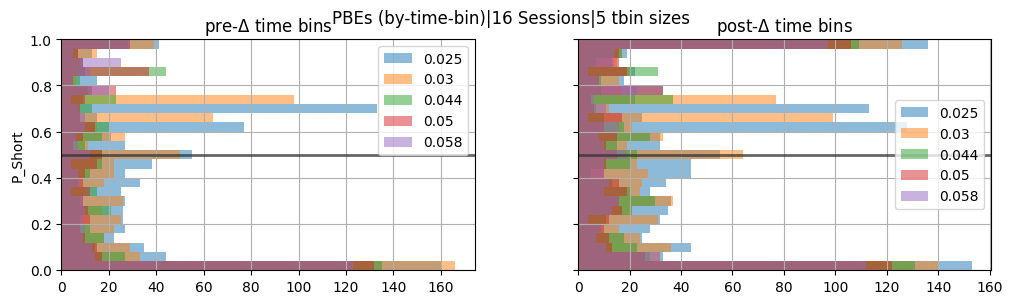

In [ ]:
matplotlib.use('Qt5Agg')
# grainularity_desc: str = 'by-time-bin'
# laps_df: pd.DataFrame = all_sessions_laps_time_bin_df
# ripple_df: pd.DataFrame = all_sessions_ripple_time_bin_df
_out_figs_dict = {}
_laps_histogram_out, _ripple_histogram_out = _perform_dual_hist_plot(grainularity_desc='by-time-bin', laps_df=all_sessions_laps_time_bin_df, ripple_df=all_sessions_ripple_time_bin_df,
																	#   legend_groups_to_solo=[0.025, 0.058], legend_groups_to_hide=None,
																	#   legend_groups_to_solo=None, legend_groups_to_hide=[0.03, 0.0444, 0.05],
																	  )

_out_figs_dict[_laps_histogram_out.context.descriptor_str] = _laps_histogram_out.figures[0]
_out_figs_dict[_ripple_histogram_out.context.descriptor_str] = _ripple_histogram_out.figures[0]

# grainularity_desc: str = 'by-epoch'
# laps_df: pd.DataFrame = all_sessions_laps_df
# ripple_df: pd.DataFrame = all_sessions_ripple_df
_laps_histogram_out, _ripple_histogram_out = _perform_dual_hist_plot(grainularity_desc='by-epoch', laps_df=all_sessions_laps_df, ripple_df=all_sessions_ripple_df)
_out_figs_dict[_laps_histogram_out.context.descriptor_str] = _laps_histogram_out.figures[0]
_out_figs_dict[_ripple_histogram_out.context.descriptor_str] = _ripple_histogram_out.figures[0]
_out_figs_dict

In [ ]:

# display(_laps_histogram_out)
# display(_ripple_histogram_out)
fig_to_clipboard(_laps_histogram_out.figures[0], bbox_inches='tight')


In [ ]:
fig_to_clipboard(_ripple_histogram_out.figures[0], bbox_inches='tight')

In [ ]:

fig_to_clipboard(_laps_histogram_out.figures[0], bbox_inches='tight')

In [ ]:
fig_to_clipboard(_ripple_histogram_out.figures[0], bbox_inches='tight')

In [ ]:
from pyphocorehelpers.plotting.media_output_helpers import figure_to_pil_image, vertical_image_stack, horizontal_image_stack, image_grid

# fig_img = figure_to_pil_image(a_fig=_ripple_histogram_out.figures[0])
# fig_img

all_img_list = []
laps_list = []
PBEs_list = []

for a_key, a_fig in _out_figs_dict.items():
	fig_img = figure_to_pil_image(a_fig=a_fig)

	if 'Laps' in a_key:
		laps_list.append(fig_img)
		
	if 'PBEs' in a_key:
		PBEs_list.append(fig_img)
		
	all_img_list.append(fig_img)
	
# all_img_list

# vertical_image_stack(laps_list)
combined_all_img = vertical_image_stack([
	horizontal_image_stack(laps_list),
	horizontal_image_stack(PBEs_list)
])
combined_all_img

copy_image_to_clipboard(combined_all_img)

# Misc

## Maintanence

In [ ]:
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass

all_session_experiment_experience_csv_path = Path("./EXTERNAL/sessions_experiment_datetime_df.csv").resolve()
Assert.path_exists(all_session_experiment_experience_csv_path)
all_session_experiment_experience_df: pd.DataFrame = pd.read_csv(all_session_experiment_experience_csv_path) # , index_col=''
all_session_experiment_experience_df


In [ ]:
all_session_experiment_experience_df = KDibaOldDataSessionFormatRegisteredClass._add_session_good_bad_annotation_status(all_session_experiment_experience_df=all_session_experiment_experience_df)
all_session_experiment_experience_df

## save it back to file
all_session_experiment_experience_df.to_csv(all_session_experiment_experience_csv_path, index=False)

## Testing Dataframes

In [ ]:
from pho_jupyter_preview_widget.display_helpers import render_scrollable_colored_table_from_dataframe, render_scrollable_colored_table
# Example 2D NumPy array
array = np.random.rand(100, 10)
# Draw it
render_scrollable_colored_table(array)

In [ ]:
# Render the DataFrame as a scrollable table with color-coded values
# scrollable_table = HTML(styled_df.set_table_attributes(f'style="display:block;overflow-x:auto;max-height:{max_height}px;width:{width};border-collapse:collapse;"').render())
df: pd.DataFrame = deepcopy(all_sessions_ripple_df)

# render_scrollable_colored_table_from_dataframe(df)

In [ ]:
df: pd.DataFrame = deepcopy(all_sessions_ripple_df)

# Performed 3 aggregations grouped on column: 'session_name'
df.groupby(['session_name']).agg(delta_aligned_start_t_nunique=('delta_aligned_start_t', 'nunique'), custom_replay_name_nunique=('custom_replay_name', 'nunique'), time_bin_size_nunique=('time_bin_size', 'nunique')).reset_index()

# Performed 3 aggregations grouped on column: 'session_name'
df.groupby(['time_bin_size', 'session_name']).agg(delta_aligned_start_t_nunique=('delta_aligned_start_t', 'nunique'), custom_replay_name_nunique=('custom_replay_name', 'nunique'), time_bin_size_nunique=('time_bin_size', 'nunique')).reset_index()

df.groupby(['time_bin_size']).agg(delta_aligned_start_t_nunique=('delta_aligned_start_t', 'nunique'), custom_replay_name_nunique=('custom_replay_name', 'nunique'), time_bin_size_nunique=('time_bin_size', 'nunique'), session_name_nunique=('session_name', 'nunique')).reset_index()

# from pyphocorehelpers.gui.Qt.pandas_model import SimplePandasModel, create_tabbed_table_widget


In [ ]:
import ipywidgets as widgets
from pyphocorehelpers.gui.Jupyter.simple_widgets import create_tab_widget
from pho_jupyter_preview_widget.display_helpers import render_scrollable_colored_table_from_dataframe

def build_df_debugging_tabbed_widget(df: pd.DataFrame, df_name: str):
	df: pd.DataFrame = deepcopy(df)
	df_dict = {"by 'session_name'": df.groupby(['session_name']).agg(delta_aligned_start_t_nunique=('delta_aligned_start_t', 'nunique'), custom_replay_name_nunique=('custom_replay_name', 'nunique'), time_bin_size_nunique=('time_bin_size', 'nunique')).reset_index(),
				"by 'time_bin_size', 'session_name'": df.groupby(['time_bin_size', 'session_name']).agg(delta_aligned_start_t_nunique=('delta_aligned_start_t', 'nunique'), custom_replay_name_nunique=('custom_replay_name', 'nunique'), time_bin_size_nunique=('time_bin_size', 'nunique')).reset_index(),
				"by 'time_bin_size'": df.groupby(['time_bin_size']).agg(delta_aligned_start_t_nunique=('delta_aligned_start_t', 'nunique'), custom_replay_name_nunique=('custom_replay_name', 'nunique'), time_bin_size_nunique=('time_bin_size', 'nunique'), session_name_nunique=('session_name', 'nunique')).reset_index(),
				}
	# tab_widget = create_tab_widget(df_dict)
	# display(tab_widget)
	# render_scrollable_colored_table_from_dataframe(df_dict['DataFrame 1'])
	formatted_df_dict = {k:render_scrollable_colored_table_from_dataframe(v, is_dark_mode=False, cmap_name=None) for k, v in df_dict.items()}
	tab_widget = create_tab_widget(formatted_df_dict,
									# layout=widgets.Layout(width='900px'),
			# style={'description_width': 'initial'},
	)
	# Create the label widget
	label = widgets.Label(
		value=df_name,
		layout=widgets.Layout(width='100%', justify_content='center', padding='10px 0')
	)
	# Stack the label and tab widget vertically
	vbox = widgets.VBox([label, tab_widget])

	# display(df_name, tab_widget)
	display(vbox)
	
# build_df_debugging_tabbed_widget(df=all_sessions_ripple_df)

dfs_dict = {'all_sessions_ripple_df':all_sessions_ripple_df, 'all_sessions_MultiMeasure_ripple_df':all_sessions_MultiMeasure_ripple_df, 'all_sessions_all_scores_ripple_df':all_sessions_all_scores_ripple_df}
for name, a_df in dfs_dict.items():
	build_df_debugging_tabbed_widget(df=a_df, df_name=name)

In [ ]:
build_df_debugging_tabbed_widget(df=all_sessions_MultiMeasure_ripple_df)


In [ ]:
build_df_debugging_tabbed_widget(df=all_sessions_all_scores_ripple_df)


In [ ]:
render_scrollable_colored_table(df.groupby(['session_name']).agg(delta_aligned_start_t_nunique=('delta_aligned_start_t', 'nunique'), custom_replay_name_nunique=('custom_replay_name', 'nunique'), time_bin_size_nunique=('time_bin_size', 'nunique')).reset_index())


## Session Enumerations

In [ ]:
# dataframes = {
# 	'all_sessions_ripple_df': all_sessions_ripple_df,
# 	'all_sessions_ripple_time_bin_df': all_sessions_ripple_time_bin_df,
# 	'all_sessions_simple_pearson_ripple_df': all_sessions_simple_pearson_ripple_df,
# 	'all_sessions_wcorr_ripple_df': all_sessions_wcorr_ripple_df,
# 	'all_sessions_all_scores_ripple_df': all_sessions_all_scores_ripple_df
# }


# dataframes = deepcopy(df_filter.filtered_df_dict)
dataframes = deepcopy(df_filter.original_df_dict)
for name, df in dataframes.items():
	unique_time_bin_counts = df.groupby('custom_replay_name')['time_bin_size'].nunique()
	print(f"== '{name}':")
	print(unique_time_bin_counts)


In [ ]:
all_sessions_ripple_df['custom_replay_name'].unique()
all_sessions_ripple_time_bin_df['custom_replay_name'].unique()
all_sessions_simple_pearson_ripple_df['custom_replay_name'].unique()
all_sessions_all_scores_ripple_df['custom_replay_name'].unique() 

# ['', 'withOldestImportedReplays-qclu_XX-frateThresh_0.1',
# 'withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0',
# 'withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0',
# 'withNormalComputedReplays-qclu_[1,2]-frateThresh_1.0']


all_sessions_all_scores_ripple_df['custom_replay_name'].unique() ## OH no, only this one is missing values

In [ ]:
all_sessions_ripple_df

In [ ]:
# sess_names, replay_names = all_sessions_ripple_df['session_name'].str.split('__') # , maxsplit=1

for a_split in all_sessions_ripple_df['session_name'].str.split('__'):
	print(f'a_split: {a_split}')

	if len(a_split) > 1:
		print(f'a_split: {a_split}')


In [ ]:
all_sessions_ripple_time_bin_df['custom_replay_name'].unique()
# all_sessions_ripple_df['custom_replay_name'].unique()

In [ ]:
# pd.set_option('display.min_rows', 50)
# pd.set_option('display.max_rows', 50)
# pd.set_option('display.show_dimensions', True)

with pd.option_context('display.min_rows', 50, 'display.show_dimensions', True):
	# max_elements
	display(parsed_csv_files_df)

# parsed_csv_files_df[parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df']


In [ ]:
parsed_csv_files_df[parsed_csv_files_df['file_type'] == 'ripple_all_scores_merged_df']

# all_sessions_all_scores_ripple_df


In [ ]:
all_sessions_ripple_time_bin_df

In [ ]:
print(list(np.unique(parsed_csv_files_df.file_type))) # ['laps_marginals_df', 'laps_simple_pf_pearson_merged_df', 'laps_time_bin_marginals_df', 'laps_weighted_corr_merged_df', 'merged_complete_epoch_stats_df', 'ripple_all_scores_merged_df', 'ripple_marginals_df', 'ripple_simple_pf_pearson_merged_df', 'ripple_time_bin_marginals_df', 'ripple_weighted_corr_merged_df']